# Riemannian Score Diffusion Means

In [1]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts, dWs
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics import diffusion_mean as dm_bridge
from jaxgeometry.stochastics import Brownian_coords, product_sde, Brownian_sR
from jaxgeometry.stochastics.product_sde import tile
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap
import jax.random as jrandom

import scipy.io as sio

import os

from load_manifold import get_generator_dim, load_manifold

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader, generators
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from models import models

2024-05-15 22:48:21.528429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
s1loss_type = 'dsm'
s2loss_type = 'dsm'
s2_type = 's1s2'
s2_approx = 0
seed = 2712

score_path = "scores"

In [4]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)
    layers_s1, layers_s2 = layers

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

## Conceptual Plot

In [5]:
figure_path = '../figures/conceptual/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [6]:
M, x0, ScoreEval = load_score_model("Sphere", 2)
Brownian_coords(M)

using M.Exp for Logarithm


In [7]:
N_sim = 5
(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0 = M.coords([0.]*2)
x0s = tile(x0, N_sim)

_dts = dts(T=1.0, n_steps=1000)
dW = dWs(N_sim*M.dim,_dts).reshape(-1,N_sim,M.dim)
(ts,xss,chartss,*_) = product(x0s,
                              _dts,dW,jnp.repeat(1.,N_sim))
chartss = vmap(lambda x,y: vmap(lambda x,chart: M.F((x,chart)))(x,y))(xss, chartss)

t = ts[jnp.arange(200,len(ts)+200, 200)]
xs = xss[jnp.arange(200,len(xss)+200, 200)]
chart = chartss[jnp.arange(200,len(chartss)+200, 200)]

In [8]:
N_sim = 5
(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0s = tile(x0, N_sim)

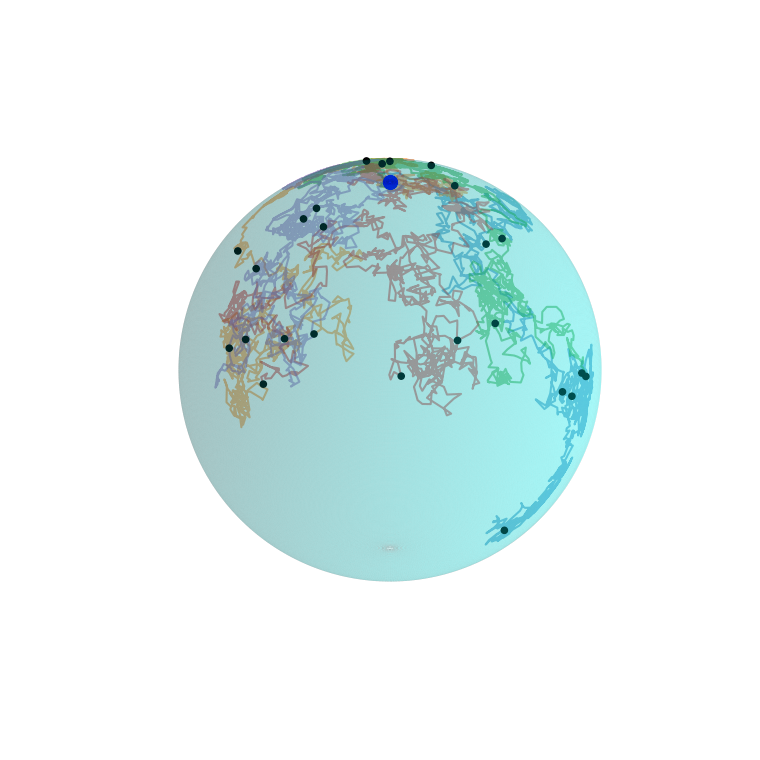

In [9]:
# Creating the theta and phi values.
intervals = 500

theta = jnp.linspace(0.0, jnp.pi*1, intervals)
phi   = jnp.linspace(0.0, jnp.pi*2, intervals)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(intervals))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, intervals, intervals), 
                     X2.reshape(1, intervals, intervals), 
                     X3.reshape(1, intervals, intervals))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig(f'{figure_path}s2_samples.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

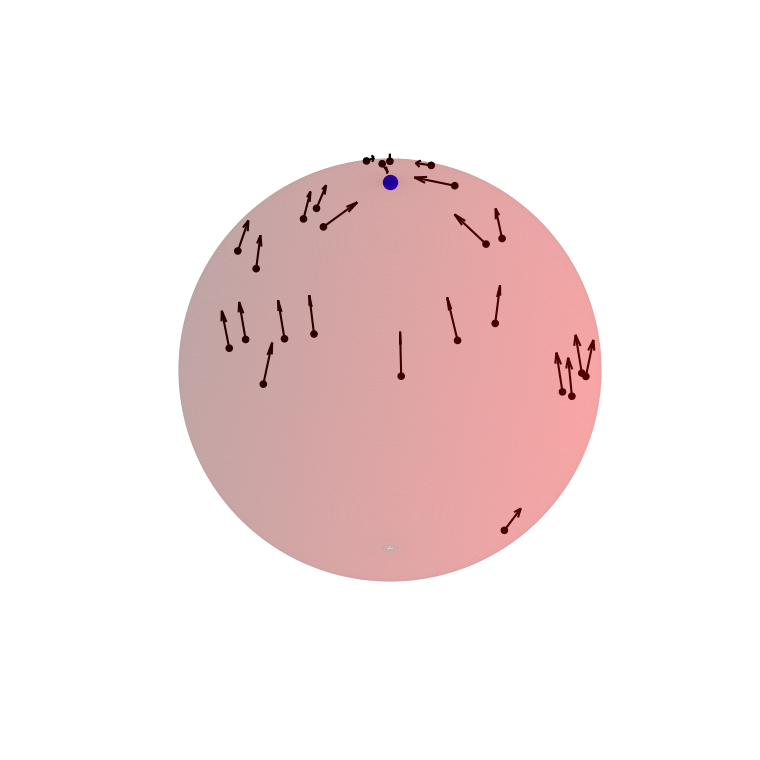

In [10]:
# Creating the theta and phi values.
intervals = 500

theta = jnp.linspace(0.0, jnp.pi*1, intervals)
phi   = jnp.linspace(0.0, jnp.pi*2, intervals)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(intervals))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, intervals, intervals), 
                     X2.reshape(1, intervals, intervals), 
                     X3.reshape(1, intervals, intervals))), axes=(1,2,0))

TM_grad_log = vmap(lambda x,chart,t: vmap(lambda x,y: M.grady_log_hk(x0,(x,y),t)[1])(x,chart))(xs,chart,t)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='red', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
ax.quiver(chart[:,:,0], chart[:,:,1], chart[:,:,2], 
          TM_grad_log[:,:,0], TM_grad_log[:,:,1], TM_grad_log[:,:,2], color='black', length=0.2, normalize=True)
#for i in range(N_sim):
#    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig(f'{figure_path}s2_gradients.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Score Diffusion Mean

In [29]:
figure_path = '../figures/diffusion_mean/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

### Synthetic Data

#### $\mathbb{S}^{2}$

In [11]:
M, x0, ScoreEval = load_score_model("Sphere", 2)
data_folder = '../data/'
t0 = 0.2

using M.Exp for Logarithm


In [12]:
Brownian_coords(M)
dm_bridge(M)

In [13]:
data_path = f"{data_folder}Sphere2/"
xs = pd.read_csv(''.join((data_path, 'xs.csv')), header=None)
charts = pd.read_csv(''.join((data_path, 'chart.csv')), header=None)
S2_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [14]:
dm_score(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], 
                     s2_model = M.gradt_log_hk, method="Gradient")
S2mu_sm, S2T_sm, gradx_sm, _ = M.sm_dmxt(S2_obs, (S2_obs[0][0], S2_obs[1][0]), jnp.array([t0]), \
                                                       step_size=0.01, max_iter=1000)
S2T_opt = S2T_sm[-1]
S2mu_opt = (S2mu_sm[0][-1], S2mu_sm[1][-1])

In [15]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = ScoreEval.gradt_log, method="Gradient")

In [16]:
S2mu_sm, S2T_sm, gradx_sm, _ = M.sm_dmxt(S2_obs, (S2_obs[0][0], S2_obs[1][0]), jnp.array([t0]), \
                                                   step_size=0.01, max_iter=1000)

In [17]:
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(S2_obs,
                                                                           num_steps=100,
                                                                           N=1)
            
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
S2mu_bridgex, S2mu_bridgechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)

Step 0 | T: 9.434431e+00 | T: ((Array([ 2.06859149e-19, -0.00000000e+00], dtype=float64), Array(0.21, dtype=float64)), Array([-0.28906656, -0.0097911 ,  0.95725893], dtype=float64))
Step 1 | T: 8.204310e+00 | T: ((Array([ 0.0057195 , -0.00872916], dtype=float64), Array(0.21991974, dtype=float64)), Array([-0.28906656, -0.0097911 ,  0.95725893], dtype=float64))
Step 2 | T: 7.253267e+00 | T: ((Array([ 0.00920802, -0.01800505], dtype=float64), Array(0.22971853, dtype=float64)), Array([-0.28906656, -0.0097911 ,  0.95725893], dtype=float64))
Step 3 | T: 6.437173e+00 | T: ((Array([ 0.01121701, -0.02746695], dtype=float64), Array(0.23935933, dtype=float64)), Array([-0.28906656, -0.0097911 ,  0.95725893], dtype=float64))
Step 4 | T: 5.740285e+00 | T: ((Array([ 0.01215278, -0.03694489], dtype=float64), Array(0.24881114, dtype=float64)), Array([-0.28906656, -0.0097911 ,  0.95725893], dtype=float64))
Step 5 | T: 5.144281e+00 | T: ((Array([ 0.01227933, -0.04633518], dtype=float64), Array(0.25804883

Step 46 | T: 9.817947e-01 | T: ((Array([-0.027418  , -0.07188044], dtype=float64), Array(0.45569721, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 47 | T: 9.710795e-01 | T: ((Array([-0.02697626, -0.07095412], dtype=float64), Array(0.45789404, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 48 | T: 9.601911e-01 | T: ((Array([-0.02652412, -0.06999341], dtype=float64), Array(0.4600368, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 49 | T: 9.498447e-01 | T: ((Array([-0.02606591, -0.069006  ], dtype=float64), Array(0.46212818, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 50 | T: 9.395497e-01 | T: ((Array([-0.02560571, -0.06799931], dtype=float64), Array(0.46417067, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 51 | T: 9.307344e-01 | T: ((Array([-0.02514704, -0.06698002], dtype=float64), Array(0.46616

Step 92 | T: 7.354934e-01 | T: ((Array([-0.01969311, -0.04595089], dtype=float64), Array(0.52506111, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 93 | T: 7.336763e-01 | T: ((Array([-0.01973028, -0.04593746], dtype=float64), Array(0.52616092, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 94 | T: 7.310956e-01 | T: ((Array([-0.01976517, -0.0459319 ], dtype=float64), Array(0.52725012, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 95 | T: 7.289509e-01 | T: ((Array([-0.01979753, -0.04593343], dtype=float64), Array(0.52832891, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 96 | T: 7.264012e-01 | T: ((Array([-0.01982667, -0.04594134], dtype=float64), Array(0.52939742, dtype=float64)), Array([-0.0840276 , -0.00587048,  0.99644406], dtype=float64))
Step 97 | T: 7.246360e-01 | T: ((Array([-0.01985225, -0.04595484], dtype=float64), Array(0.5304

#### Landmarks 2x2

In [18]:
M, x0, ScoreEval = load_score_model("Landmarks", 2)
data_folder = '../data/'
t0 = 0.2

using M.Exp for Logarithm


In [19]:
data_path = f"{data_folder}Landmarks2/"
xs = pd.read_csv(''.join((data_path, 'xs.csv')), header=None)
charts = pd.read_csv(''.join((data_path, 'chart.csv')), header=None)
landmarks_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [20]:
landmarksmu_opt = x0

In [21]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = ScoreEval.gradt_log, method="Gradient")

In [22]:
landmarksmu_sm, landmarksT_sm, gradx_sm, _ = M.sm_dmxt(landmarks_obs, (landmarks_obs[0][0], landmarks_obs[1][0]), jnp.array([t0]), \
                                                   step_size=0.01, max_iter=1000)

#### Plotting

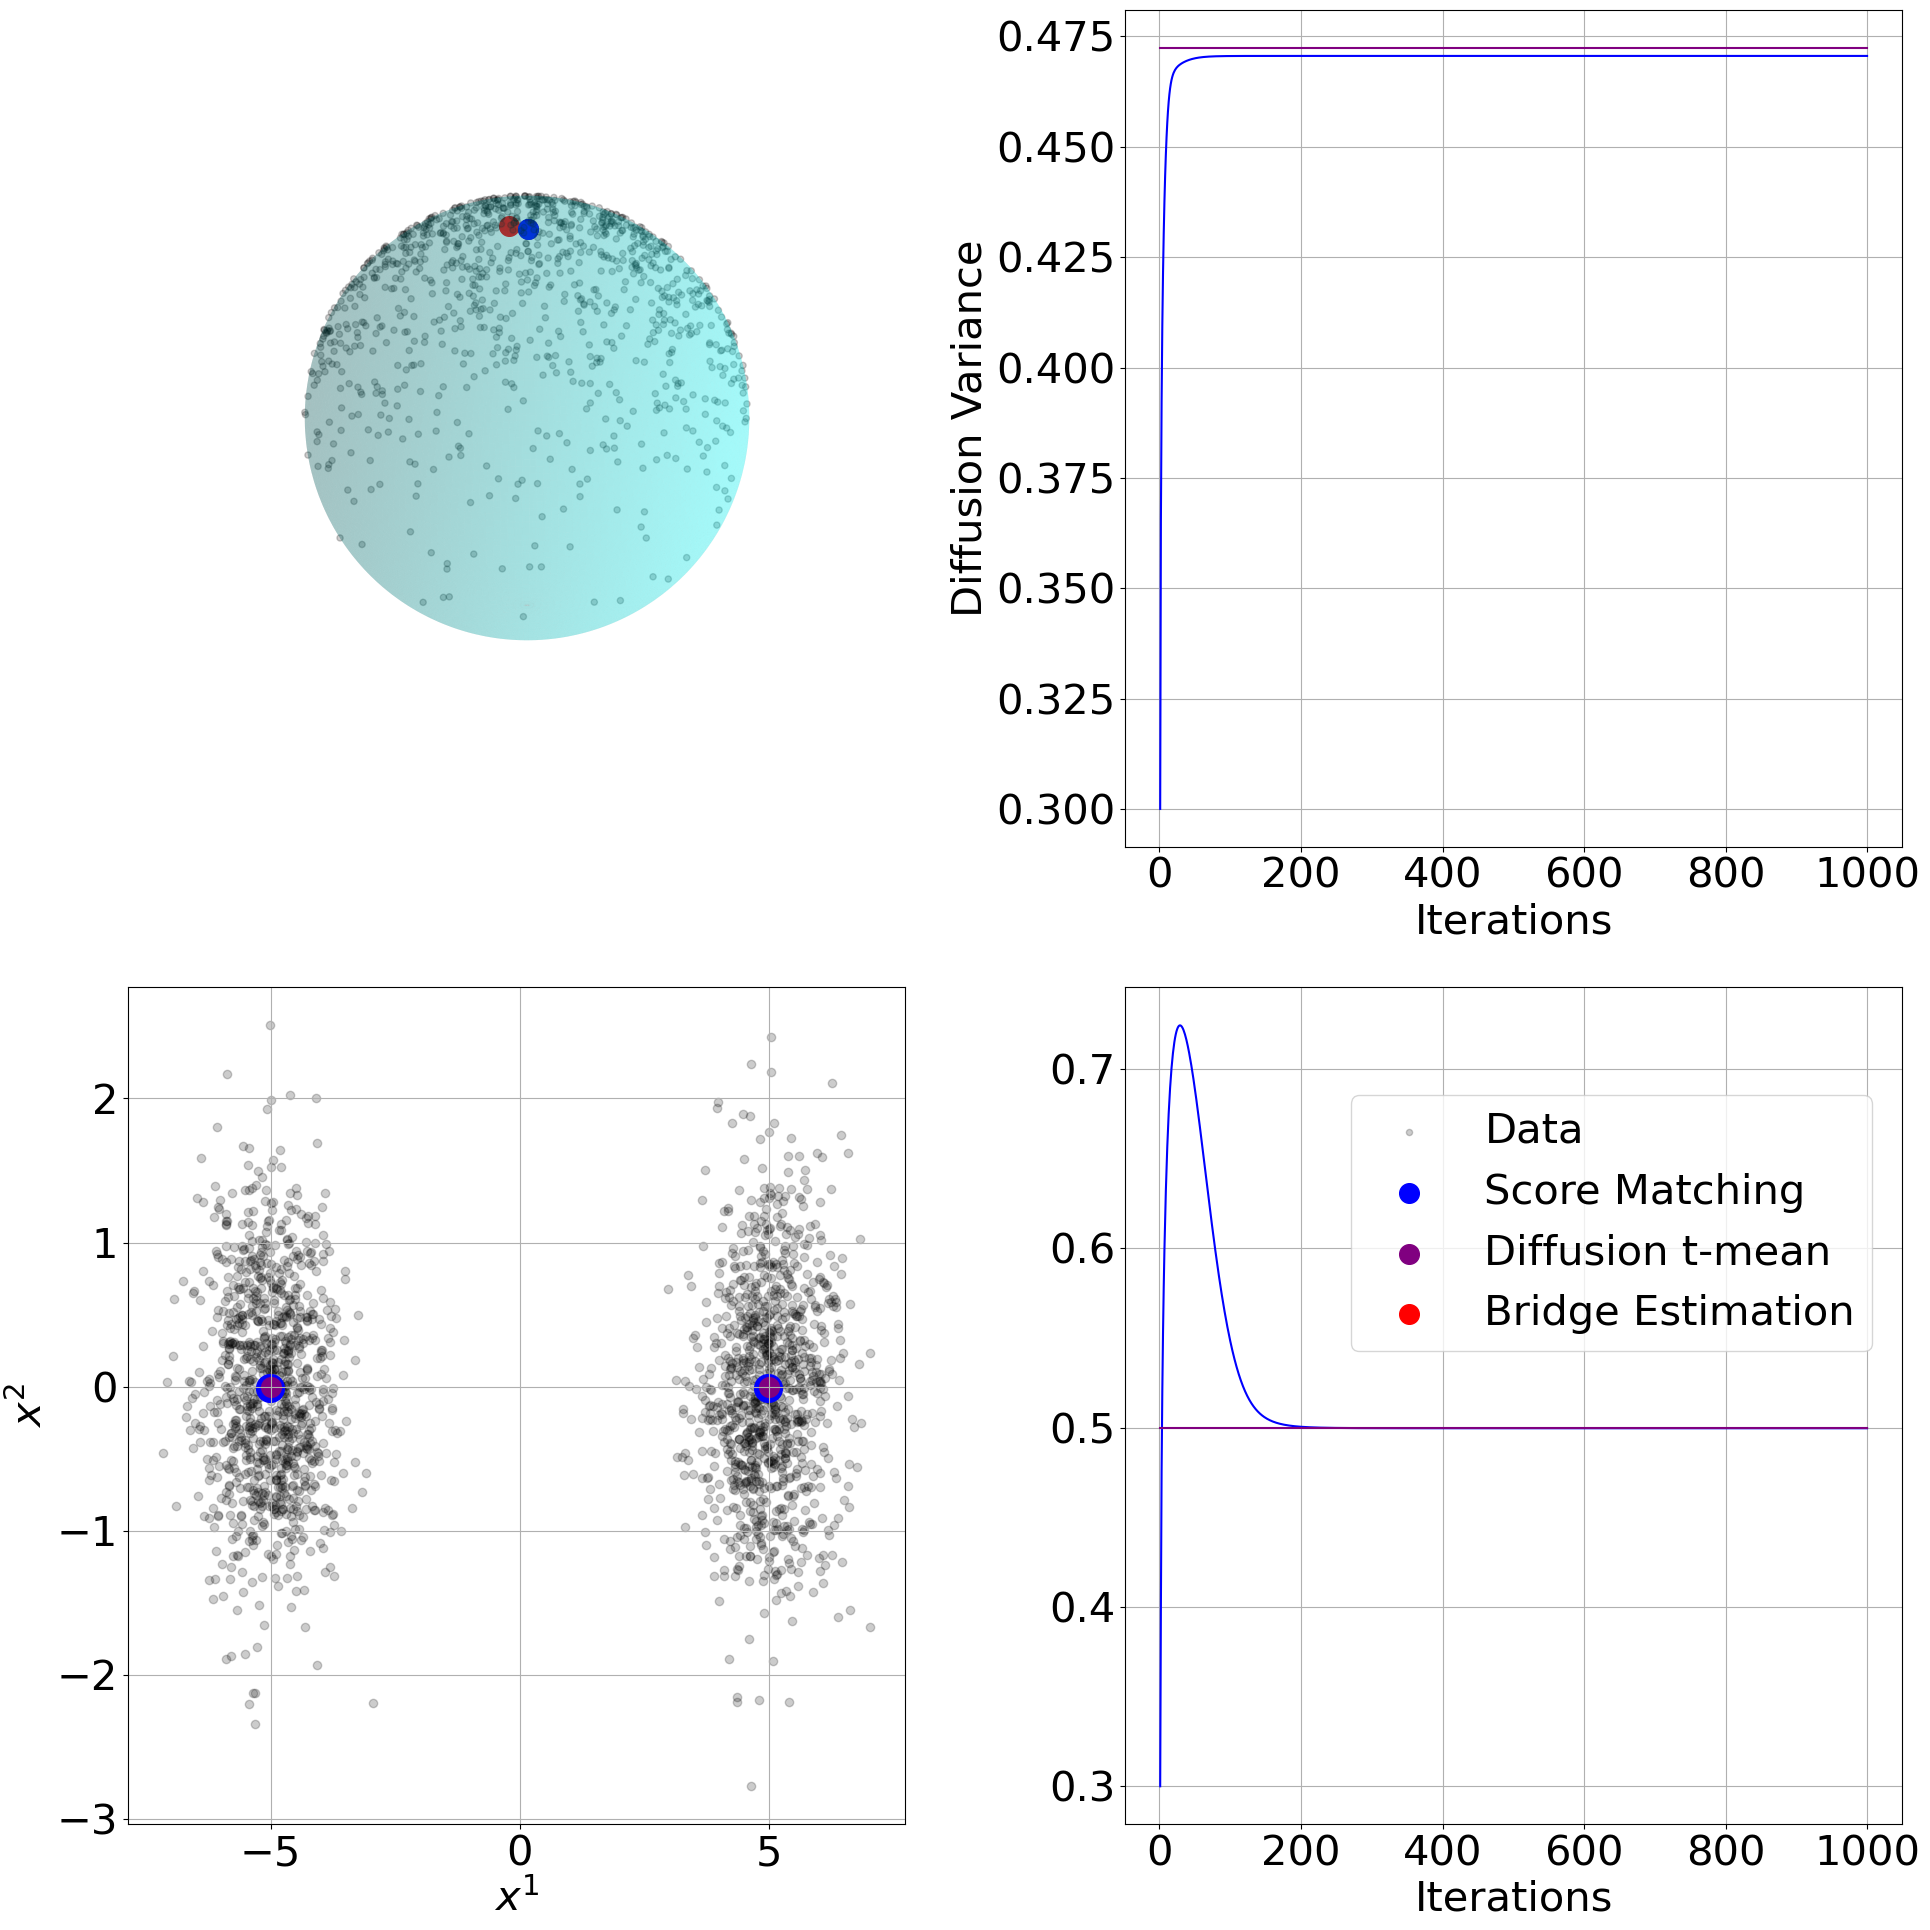

In [30]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(20,20))
#S2
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(S2_obs[1][:,0], S2_obs[1][:,1], S2_obs[1][:,2], color='black', alpha=0.2, label='Data')
ax.scatter(S2mu_sm[1][-1,0], S2mu_sm[1][-1,1], S2mu_sm[1][-1,2], color='blue', label='Score Matching', alpha=1.0, s=200)
ax.scatter(S2mu_opt[1][0], S2mu_opt[1][1], S2mu_opt[1][2], color='purple', label='Diffusion t-mean', s=200)
ax.scatter(S2mu_bridgechart[-1,0], S2mu_bridgechart[1,1], S2mu_bridgechart[2,2], color='red', label='Bridge Estimation', s=200)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(222)
ax.plot(jnp.arange(1,len(S2T_sm)+1, 1), S2T_sm, color='blue')
ax.plot(jnp.arange(1,len(S2T_sm)+1, 1), S2T_opt*jnp.ones(len(S2T_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Diffusion Variance')
fig.tight_layout()

#Landmarks
ax = fig.add_subplot(223)
obs = landmarks_obs[0].reshape(-1,2,2)
for i in range(len(obs)):
    plt.scatter(obs[i][0,0], obs[i][0,1], color='black', alpha=0.2)
    plt.scatter(obs[i][1,0], obs[i][1,1], color='black', alpha=0.2)
plt.scatter(landmarksmu_sm[0][-1].reshape(2,2)[0,0], landmarksmu_sm[0][-1].reshape(2,2)[0,1], color='blue', s=400)
plt.scatter(landmarksmu_sm[0][-1].reshape(2,2)[1,0], landmarksmu_sm[0][-1].reshape(2,2)[1,1], color='blue', s=400)
plt.scatter(x0[0].reshape(2,2)[0,0], x0[0].reshape(2,2)[0,1], color='purple', s=200)
plt.scatter(x0[0].reshape(2,2)[1,0], x0[0].reshape(2,2)[1,1], color='purple', s=200)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(224)
ax.plot(jnp.arange(1,len(landmarksT_sm)+1, 1), landmarksT_sm, color='blue')
ax.plot(jnp.arange(1,len(landmarksT_sm)+1, 1), 0.5*jnp.ones(len(landmarksT_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.7,0.3), ncol=1)

plt.show()

fig.savefig(f'{figure_path}synthetic_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

### Real-World Data

#### GP - MNIST

In [34]:
M, x0, ScoreEval = load_score_model("gp_mnist", 2)

using M.Exp for Logarithm


In [35]:
from gp.gp import RM_EG
default_omega = 500.
        
def k_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = x-y

    return beta*jnp.exp(-omega*jnp.dot(x_diff, x_diff)/2)

def Dk_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = y-x

    return omega*x_diff*k_fun(x,y,beta,omega)

def DDk_fun(x,y, beta=1.0, omega=default_omega):

    N = len(x)
    x_diff = (x-y).reshape(1,-1)

    return -omega*k_fun(x,y,beta,omega)*(x_diff.T.dot(x_diff)*omega-jnp.eye(N))

rot = jnp.load('Data/MNIST/rot.npy')
num_rotate = len(rot)

theta = jnp.linspace(0,2*jnp.pi,num_rotate)
x1 = jnp.cos(theta)
x2 = jnp.sin(theta)

sigman = 0.0
X_training = jnp.vstack((x1,x2))
y_training = rot.reshape(num_rotate, -1).T
RMEG = RM_EG(X_training, y_training, sigman=sigman, k_fun=k_fun, 
             Dk_fun = Dk_fun, DDk_fun = DDk_fun, delta_stable=1e-10)

g = lambda x: RMEG.G(x[0])

M = LearnedManifold(g,N=2)
generator_dim = M.dim
x0 = M.coords(jnp.array([jnp.cos(0.), jnp.sin(0.)]))
sampling_method = 'LocalSampling'
layers = [50,100,200,400,800,800,400,200,100,50]
opt_val = 'x0'

using M.Exp for Logarithm


In [36]:
gpmnist_obs = (X_training[:,:len(rot)//2].T, jnp.zeros(len(rot)//2).reshape(-1,1))

In [37]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = lambda x,y,t: ScoreEval.gradt_log(x,y,t), method="JAX")

In [38]:
gpmnistmu_sm, gpmnistT_sm, *_ = M.sm_dmxt(gpmnist_obs, (gpmnist_obs[0][0], gpmnist_obs[1][0]), jnp.array([t0]), \
                                                   step_size=0.01, max_iter=1000)

In [50]:
gp_mu = RMEG.post_mom(gpmnistmu_sm[0][-1])[0]
data_post = vmap(lambda x: RMEG.post_mom(x)[0])(gpmnist_obs[0])
mnist_data = torch.Tensor(np.array(data_post.reshape(-1,1,28,28)))

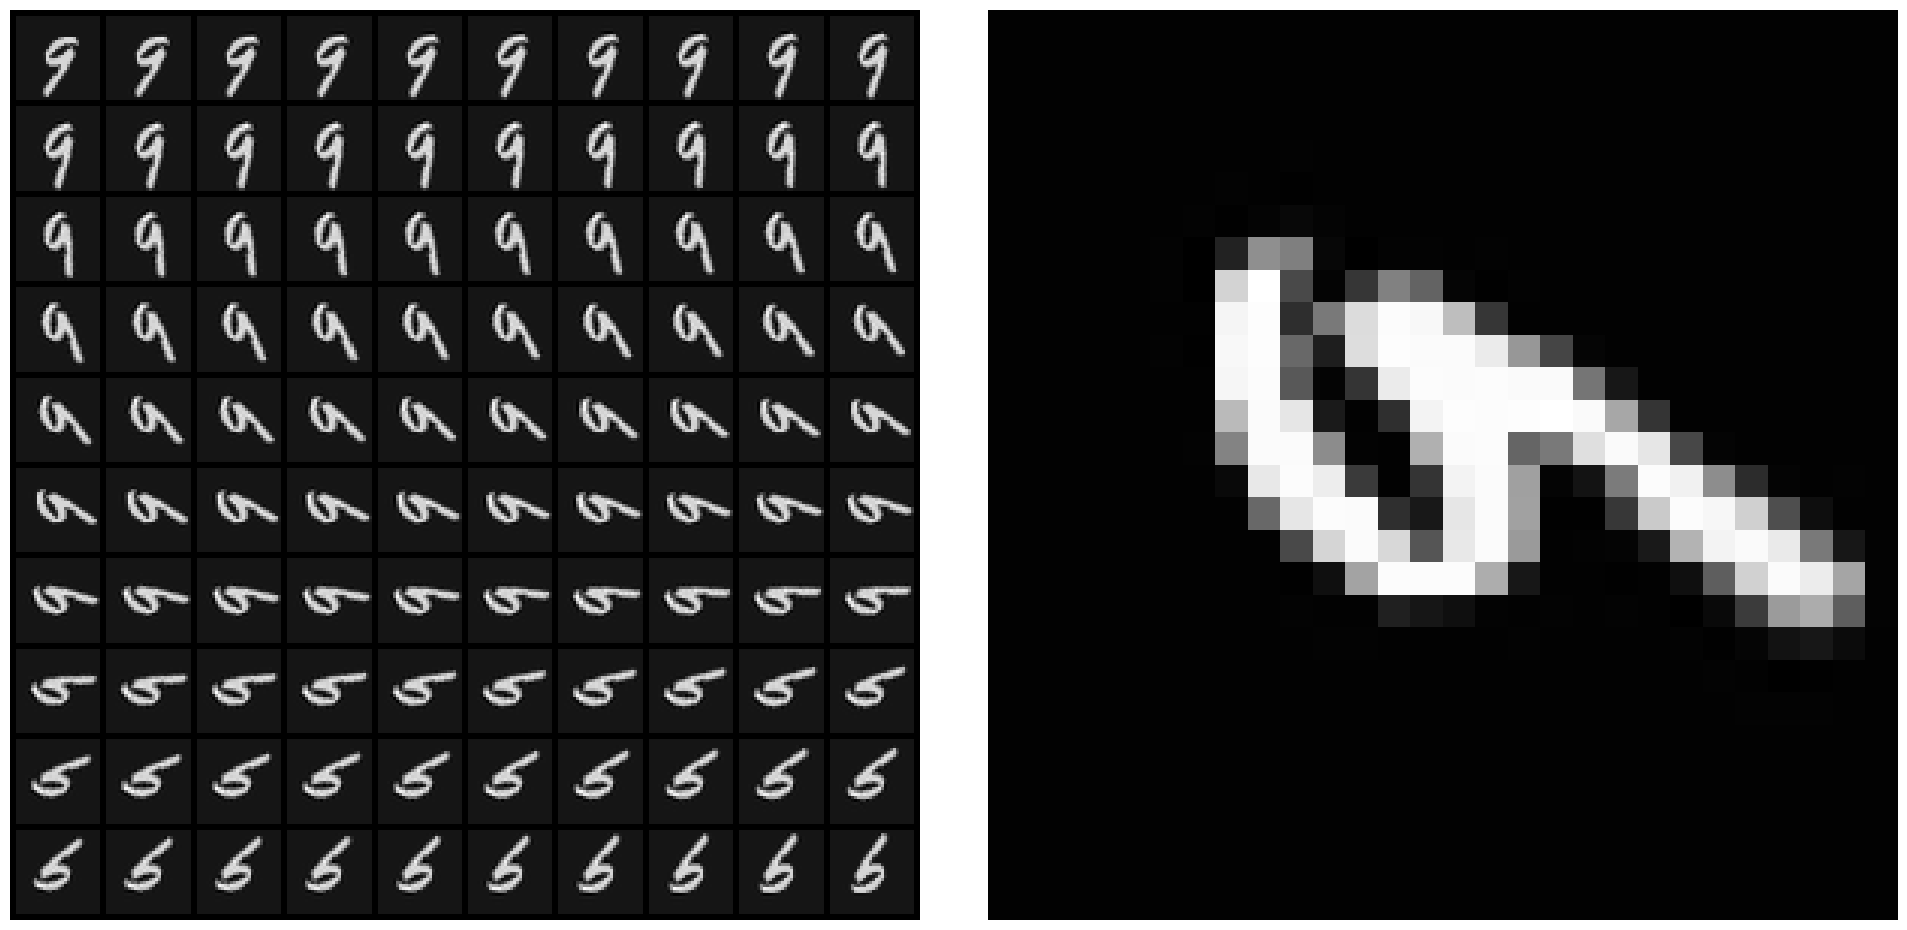

In [49]:
import torch
import torchvision.utils as vutils
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.imshow(np.transpose(vutils.make_grid(mnist_data.to('cpu'), padding=2, normalize=True, nrow=10).cpu(),(1,2,0)))
ax.set_axis_off()
ax = fig.add_subplot(122)
ax.imshow(gp_mu.reshape(28,28), cmap='gray')
ax.set_axis_off()
fig.tight_layout()

#### Landmarks - Cardiac Data

In [40]:
dim = 20

In [41]:
sampling_method = 'LocalSampling'
M = Landmarks(N=dim,m=2)   
generator_dim = M.dim
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,0.0,M.N),jnp.linspace(5.0,0.0,M.N))).T.flatten())
if dim >=10:
    with open('../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]

        x1 = jnp.array([float(x) for x in all_data[0].split()[2:]])
        x2 = jnp.array([float(x) for x in all_data[1].split()[2:]])

        idx = jnp.round(jnp.linspace(0, len(x1) - 1, dim)).astype(int)
        x0 = M.coords(jnp.vstack((x1[idx],x2[idx])).T.flatten())
opt_val = "x0"
layers = get_generator_dim(generator_dim)

using M.Exp for Logarithm


In [49]:
import os
import imageio
path = '../../../../../Data/landmarks/cardiac/'
cardiac_image= imageio.imread(os.path.join(path,'c4480h_s1.png'))

import scipy as sp

def crop(image, x1, x2, y1, y2):
    """
    Return the cropped image at the x1, x2, y1, y2 coordinates
    """
    if x2 == -1:
        x2=image.shape[1]-1
    if y2 == -1:
        y2=image.shape[0]-1

    mask = np.zeros(image.shape)
    mask[y1:y2+1, x1:x2+1]=1
    m = mask>0

    return image[m].reshape((y2+1-y1, x2+1-x1))

cardiac_image = crop(cardiac_image, 90, 175, 80, 160)

/tmp/ipykernel_614077/862055378.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  cardiac_image= imageio.imread(os.path.join(path,'c4480h_s1.png'))


In [50]:
import glob

#%% Hyper-parameters
N_sample = 20
n = 66
d = 2

files = glob.glob("../../../../../Data/landmarks/cardiac/*.asf")
K = len(files)

qs = jnp.zeros((K,n,d))
for j in range(K):
    try:
        in_file = open(files[j], 'r')

        NN = -1
        for line in in_file.readlines():
            if len(line) > 1 and line[0] != '#':
                splits = line.split()
                if NN < 0 and len(splits) == 1:
                    NN = int(splits[0])
                    q = jnp.zeros((n,d))
                    i = 0
                if len(splits) >= 7:
                    q = q.at[i,0].set(float(splits[2]))
                    q = q.at[i,1].set(float(splits[3]))
                    i = i + 1 
    finally:
        in_file.close()
    qs = qs.at[j].set(q-jnp.tile(jnp.mean(q,axis=0),((q.shape[0],1))))


idx = jnp.round(np.linspace(0, qs.shape[1] - 1, N_sample)).astype(int)
landmark_data = qs[:,idx].reshape(qs.shape[0],-1)*1000

In [51]:
cardiac_obs = (landmark_data, jnp.zeros(len(landmark_data)))

In [52]:
s1_path = f"../scores/Landmarks20/s1_{s1loss_type}/"
s2_path = f"../scores/Landmarks20/{s2_type}_{s2loss_type}/"
generator_dim = M.dim

s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))
        
if s2_type == "s2":
    s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=generator_dim, r = max(generator_dim//2,1))(x))
elif s2_type == "s1s2":
    @hk.transform
    def s2_model(x):

        s1s2 =  models.MLP_s1s2(
            models.MLP_s1(dim=generator_dim, layers=layers), 
            models.MLP_s2(layers_alpha=layers, 
                          layers_beta=layers,
                          dim=generator_dim,
                          r = max(generator_dim//2,1))
            )

        return s1s2(x)[1]

In [53]:
s1_state = model_loader.load_model(s1_path)
if s2_approx:
    s2_state = model_loader.load_model(s2_path)
else:
    s2_state = None

ScoreEval = ScoreEvaluation(M,
                            s1_model=s1_model,
                            s1_state=s1_state,
                            s2_model=s2_model,
                            s2_state=s2_state,
                            s2_approx=s2_approx, 
                            method='Local',
                            seed=2712)

In [54]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = lambda x,y,t: ScoreEval.gradt_log(x,y,t), method="JAX")

In [55]:
cardiacmu_sm, cardiacT_sm, *_ = M.sm_dmxt(cardiac_obs, (cardiac_obs[0][0], cardiac_obs[1][0]), jnp.array([0.2]), \
                                                   step_size=0.01, max_iter=1000)

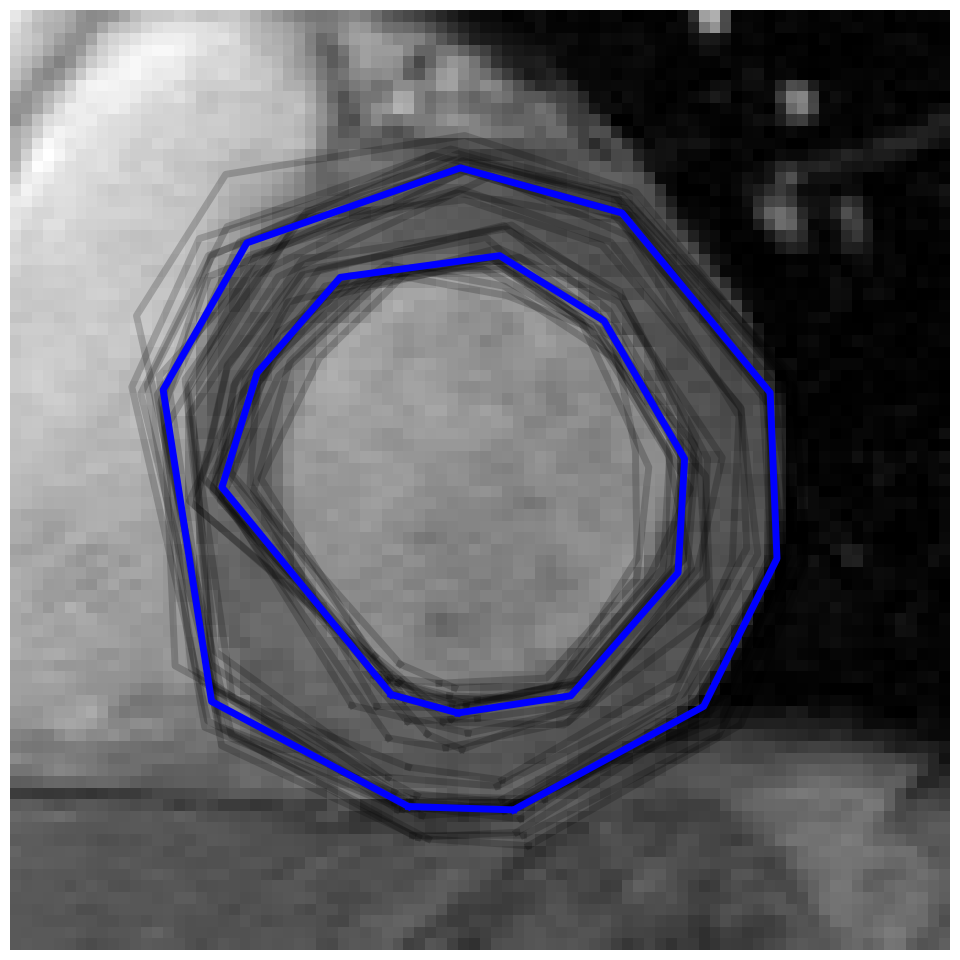

In [56]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(cardiac_image, interpolation='none', extent=[-150.0,150.0, -150.0, 150.0], cmap='gray')
ax.set_aspect(1)
N_half = N_sample // 2
mu = cardiacmu_sm[0][-1].reshape(-1,2)/1
for wing in cardiac_obs[0]:
    wing = wing.reshape(-1,2)/1
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2,linewidth=5)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2, linewidth=5)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue', linewidth=5)
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue', linewidth=5)
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

#### Landmarks - Butterfly Data

In [57]:
dim = 20

In [58]:
sampling_method = 'LocalSampling'
M = Landmarks(N=dim,m=2)   
generator_dim = M.dim
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,0.0,M.N),jnp.linspace(5.0,0.0,M.N))).T.flatten())
if dim >=10:
    with open('../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]

        x1 = jnp.array([float(x) for x in all_data[0].split()[2:]])
        x2 = jnp.array([float(x) for x in all_data[1].split()[2:]])

        idx = jnp.round(jnp.linspace(0, len(x1) - 1, dim)).astype(int)
        x0 = M.coords(jnp.vstack((x1[idx],x2[idx])).T.flatten())
opt_val = "x0"
layers = get_generator_dim(generator_dim)

using M.Exp for Logarithm


In [59]:
data = pd.read_csv('../../../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [60]:
with open('../../../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [61]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)
    idx = jnp.round(np.linspace(0, len(data1) - 1, N_sample)).astype(int)
    landmark_data.append(jnp.vstack((data1[idx], data2[idx])).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [62]:
butterfly_obs = (jnp.array(landmark_data, dtype=jnp.float64), jnp.zeros(len(landmark_data)))

In [63]:
s1_path = f"../scores/Landmarks20/s1_{s1loss_type}/"
s2_path = f"../scores/Landmarks20/{s2_type}_{s2loss_type}/"
generator_dim = M.dim

s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))
        
if s2_type == "s2":
    s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=generator_dim, r = max(generator_dim//2,1))(x))
elif s2_type == "s1s2":
    @hk.transform
    def s2_model(x):

        s1s2 =  models.MLP_s1s2(
            models.MLP_s1(dim=generator_dim, layers=layers), 
            models.MLP_s2(layers_alpha=layers, 
                          layers_beta=layers,
                          dim=generator_dim,
                          r = max(generator_dim//2,1))
            )

        return s1s2(x)[1]

In [64]:
s1_state = model_loader.load_model(s1_path)
if s2_approx:
    s2_state = model_loader.load_model(s2_path)
else:
    s2_state = None

ScoreEval = ScoreEvaluation(M,
                            s1_model=s1_model,
                            s1_state=s1_state,
                            s2_model=s2_model,
                            s2_state=s2_state,
                            s2_approx=s2_approx, 
                            method='Local',
                            seed=2712)

In [65]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = lambda x,y,t: ScoreEval.gradt_log(x,y,t), method="JAX")

In [66]:
butterflymu_sm, butterflyT_sm, *_ = M.sm_dmxt(butterfly_obs, (butterfly_obs[0][0], butterfly_obs[1][0]), jnp.array([0.2]), \
                                                   step_size=0.01, max_iter=1000)

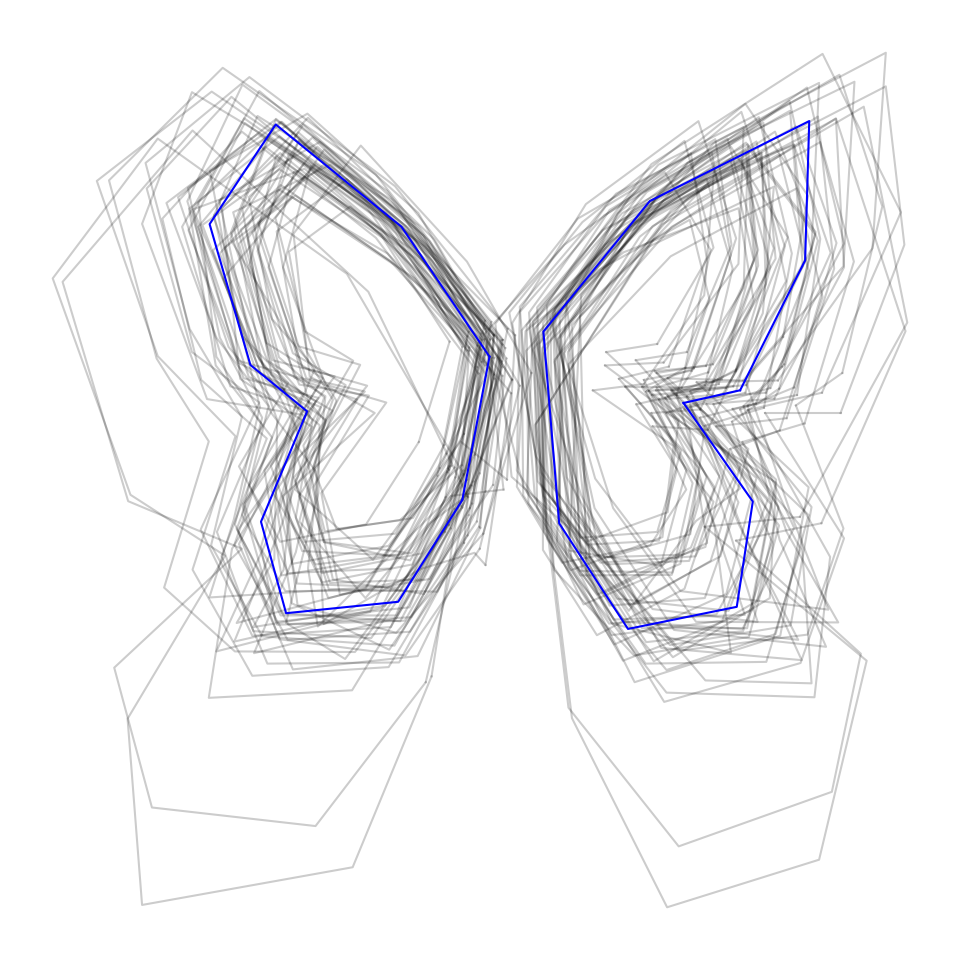

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
N_half = N_sample // 2
mu = butterflymu_sm[0][-1].reshape(-1,2)
for wing in butterfly_obs[0]:
    wing = wing.reshape(-1,2)
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

## Riemannian K-Means

### $\mathbb{S}^{2}$

## Riemannian Brownian Mixture Model 

### $\mathbb{S}^{2}$

## Maximum Likelihood Estimation

### $\mathbb{S}^{2}$

In [177]:
from load_manifold import get_generator_dim
M = nSphere(N=2)
Brownian_coords(M)
dm_bridge(M)
x0 = M.coords([0.0]*2)
layers = get_generator_dim(3)

using M.Exp for Logarithm


In [178]:
s1_path = f"../scores/Sphere2/s1_{s1loss_type}/"
s2_path = f"../scores/Sphere2/{s2_type}_{s2loss_type}/"
generator_dim = 3

s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))
        
if s2_type == "s2":
    s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=generator_dim, r = max(generator_dim//2,1))(x))
elif s2_type == "s1s2":
    @hk.transform
    def s2_model(x):

        s1s2 =  models.MLP_s1s2(
            models.MLP_s1(dim=generator_dim, layers=layers), 
            models.MLP_s2(layers_alpha=layers, 
                          layers_beta=layers,
                          dim=generator_dim,
                          r = max(generator_dim//2,1))
            )

        return s1s2(x)[1]

In [179]:
s1_state = model_loader.load_model(s1_path)
if s2_approx:
    s2_state = model_loader.load_model(s2_path)
else:
    s2_state = None

In [180]:
ScoreEval = ScoreEvaluation(M,
                            s1_model=s1_model,
                            s1_state=s1_state,
                            s2_model=s2_model,
                            s2_state=s2_state,
                            s2_approx=s2_approx, 
                            method='Embedded',
                            seed=2712)

In [181]:
from jaxgeometry.statistics.score_matching import MLGeodesicRegression

In [182]:
geodesic_data = vmap(lambda t: M.ExpEmbedded(x0[1], jnp.array([-0.5,-0.5,0.0]), t=t))(jnp.linspace(0.1,1.0,100))

In [183]:
geodesic_data = vmap(lambda t: M.ExpEmbedded(x0[1], jnp.array([-0.5,-0.5,0.0]), t=t))(jnp.linspace(0.1,1.0,100))
data = geodesic_data+0.01*np.random.normal(0,1,(len(geodesic_data),3))
data = vmap(lambda d: d/jnp.linalg.norm(d))(data)
geodesic_data = (vmap(lambda c: M.invF((c,c)))(data), data)

In [184]:
from jax import jacfwd
mlgr = MLGeodesicRegression(M,
                           ScoreEval.grady_proj,#lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                           ScoreEval.gradt_log,#lambda x,y,t: M.gradt_log_hk(x,y,t),
                            Exp = lambda x,v: M.ExpEmbeddedLocal(x[1],v),
                            gradp_exp = lambda x,v: jacfwd(lambda x: M.ExpEmbedded(x[1],v))(x)[1],
                            gradv_exp = lambda x,v: jacfwd(lambda v: M.ExpEmbedded(x[1],v))(v),
                            max_iter=1000,
                            lr_rm=0.1,
                            lr_euc=0.1,
                           )
X = jnp.linspace(0.1,1,100)
v = jnp.array([-0.5,-0.5,0.0])
mu = jnp.array([0.0,0.5,0.5])
mu = get_coords(M,mu/jnp.linalg.norm(mu))
sigma = 0.5

In [199]:
mlgr = MLGeodesicRegression(M,
                           ScoreEval.grady_log,#lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                           ScoreEval.gradt_log,#lambda x,y,t: M.gradt_log_hk(x,y,t),
                            Exp = M.Exp,
                            gradp_exp = lambda x,v: jacfwdx(lambda x: M.Exp(x,v))(x)[0],
                            gradv_exp = lambda x,v: jacfwd(lambda v: M.Exp(x,v))(v)[0],
                            max_iter=1000,
                            lr_rm=0.1,
                            lr_euc=0.1,
                           )
X = jnp.linspace(0.1,1,100)
v = jnp.array([-0.5,-0.5,0.0])
mu = jnp.array([0.0,0.5,0.5])
mu = get_coords(M,mu/jnp.linalg.norm(mu))
sigma = 0.5

In [201]:
mlgr.gradt(geodesic_data, mu, sigma, v, X)

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (3,).

In [186]:
mlgr.gradv(geodesic_data, mu, sigma, v, X)

Array([-0.12002531,  1.63199349, -0.8020608 ], dtype=float64)

In [187]:
mlgr.fit(geodesic_data, X, v, mu, jnp.array([sigma]).reshape(1), method='Gradient')

In [188]:
X.shape

(100,)

In [189]:
mlgr.sigma

Array(0.27631575, dtype=float64)

In [190]:
mlgr.sigma**2

Array(0.0763504, dtype=float64)

In [191]:
M.proj(mlgr.mu[1], mlgr.v)

Array([0.17778221, 0.58094122, 0.06143994], dtype=float64)

In [198]:
mlgr.v

Array([ 0.97656866,  1.04214625, -6.61081691], dtype=float64)

In [193]:
print(X.shape)

(100,)


In [194]:
mlgr.gradp(geodesic_data, mlgr.mu, mlgr.sigma, mlgr.v, X)

Array([-1.39112497, -3.7640651 , -0.42672481], dtype=float64)

In [195]:
mlgr.gradp(geodesic_data, mlgr.mu, mlgr.sigma, mlgr.v, X)

Array([-1.39112497, -3.7640651 , -0.42672481], dtype=float64)

In [196]:
ml_curve = vmap(lambda v: M.ExpEmbedded(mlgr.mu[1], v))(X.reshape(-1,1)*mlgr.v)

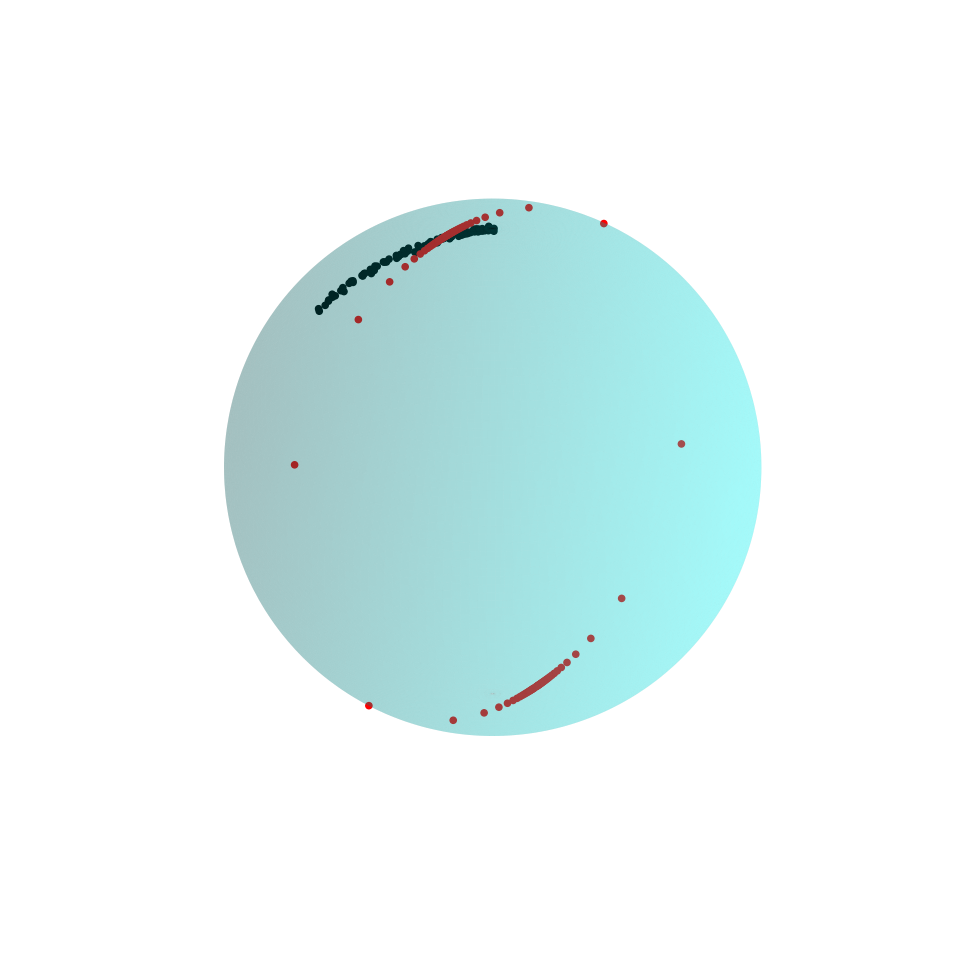

In [197]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(geodesic_data[1][:,0], geodesic_data[1][:,1], geodesic_data[1][:,2], color='black', alpha=1.0, label='Data')
ax.scatter(ml_curve[:,0], ml_curve[:,1], ml_curve[:,2], color='red', alpha=1.0, label='Data')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

## Estimation of Diffusion Mean

## Define Manifolds

In [50]:
loss_type = 'dsm'
s2_approximation = True

In [4]:
T = 0.5

In [5]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

In [6]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

### $\mathbb{R}^{2}$

In [7]:
R2 = Euclidean(N=2)
jstoch.Brownian_coords(R2)
jstat.diffusion_mean(R2)
R2_x0 = (jnp.zeros(2), jnp.zeros(1))

using M.Exp for Logarithm


In [8]:
file_path = 'scores/R2/s1_'+ loss_type + '/'
r2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_r2 = hk.transform(lambda x: models.MLP_s1(dim=R2.dim, layers=layers)(x))
s2_r2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=R2.dim, r = max(R3.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_r2(x,y,t):
    
    return s1_r2.apply(r2_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_r2(x,y,t):
    
    grad_val = grady_log_r2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_r2(x, y, t)))

def ggrady_log_r2(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_r2.apply(r2_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [9]:
N_points = 1000
min_x = -2.0
max_x = 2.0
x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)

# Creating the coordinate grid for the unit sphere.
X1_R2, X2_R2 = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_R2.reshape(1, N_points, N_points), 
                     X2_R2.reshape(1, N_points, N_points))), axes=(1,2,0))

theoretical_grad = lambda y: R2.grady_log_hk(R2_x0, (y, jnp.zeros(1)), T)[0]
numerical_grad = lambda y: grady_log_r2(R2_x0, (y, jnp.zeros(1)), T)
R2_grad = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(X_heat)
R2_angle = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)
R2_l2 = vmap(lambda x2: \
                vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

### $\mathbb{R}^{3}$

In [10]:
R3 = Euclidean(N=3)
jstoch.Brownian_coords(R3)
jstat.diffusion_mean(R3)
R3_x0 = (jnp.zeros(3), jnp.zeros(1))

using M.Exp for Logarithm


In [11]:
file_path = 'scores/R3/s1_'+ loss_type + '/'
r3_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_r3 = hk.transform(lambda x: models.MLP_s1(dim=R3.dim, layers=layers)(x))
s2_r3 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=R3.dim, r = max(R3.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_r3(x,y,t):
    
    return s1_r3.apply(r3_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_r3(x,y,t):
    
    grad_val = grady_log_r3(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_r3(x, y, t)))

def ggrady_log_r3(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_r3.apply(r3_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [12]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere
#Plotting
# Creating the theta and phi values
N_points = 100

min_x = -2.0
max_x = 2.0

x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)
x3 = jnp.linspace(min_x, max_x, N_points)

# Creating the coordinate grid for the unit sphere.
X1_r3, X2_r3, X3_r3 = jnp.meshgrid(x1, x2, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_r3.reshape(1, N_points,N_points, N_points), 
                     X2_r3.reshape(1, N_points,N_points, N_points),
                                       X3_r3.reshape(1, N_points,N_points, N_points))), axes=(1,2,3,0))

theoretical_grad = lambda y: R3.grady_log_hk(R3_x0, (y, jnp.zeros(1)), T)[0]
numerical_grad = lambda y: grady_log_r3(R3_x0, (y, jnp.zeros(1)), T)
R3_grad = vmap(lambda x3: vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(x3))(X_heat)
R3_angle = vmap(lambda x3: vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(x3))(X_heat)
R3_l2 = vmap(lambda x3: \
                vmap(lambda x2: \
                     vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(x3))(X_heat)


### $\mathbb{S}^{1}$

In [13]:
S1M = S1()
jstoch.Brownian_coords(S1M)
jstat.diffusion_mean(S1M)
S1M_x0 = S1M.coords([0.])

using M.Exp for Logarithm


In [14]:
file_path = 'scores/S1/s1_'+ loss_type + '/'
s1_state = model_loader.load_model(file_path)
layers = [50, 100, 50]
s1_s1 = hk.transform(lambda x: models.MLP_s1(dim=S1M.dim, layers=layers)(x))
s2_s1 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S1M.dim, r = max(S1M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s1(x,y,t):
    
    return s1_s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_s1(x,y,t):
    
    grad_val = grady_log_s1(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s1(x, y, t)))

def ggrady_log_s1(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [15]:
# Creating the theta and phi values.
N_points = 1000
phi_heat   = jnp.linspace(-jnp.pi, jnp.pi, N_points)

# Creating the coordinate grid for the unit sphere.
X1_s1 = jnp.cos(phi_heat)
X2_s1 = jnp.sin(phi_heat)
X_s1 = jnp.transpose(jnp.concatenate((X1_s1.reshape(1, N_points), 
                     X2_s1.reshape(1, N_points))))

theoretical_grad = lambda y: S1M.grady_log_hk(S1M_x0, (y,y), T)
numerical_grad = lambda y: grady_log_s1(S1M_x0, (y,y), T)
S1_grad = vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(phi_heat)
S1_angle = vmap(lambda x1: angle_between(theoretical_grad(x1),numerical_grad(x1)))(phi_heat)
S1_l2 = vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(phi_heat)

### $\mathbb{S}^{2}$

In [16]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [17]:
file_path = 'scores/S2/s1_'+ loss_type + '/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s2(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_s2(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log_s2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [18]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

theoretical_grad = lambda y: S2.grady_log_hk(S2_x0, get_coords(S2,y), T)[0]
numerical_grad = lambda y: grady_log_s2(S2_x0, get_coords(S2,y), T)
S2_grad = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(X_heat)
S2_angle = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)
S2_l2 = vmap(lambda x2: \
                vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

## Comparison to Analytical Gradients

### Comparison of Angle

/tmp/ipykernel_170856/823599512.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


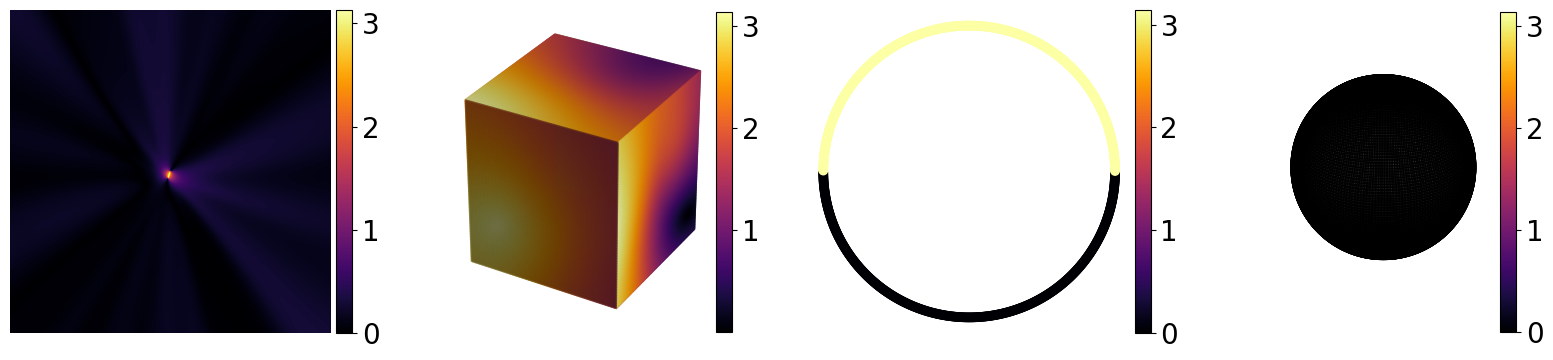

In [19]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_angle, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_angle)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_angle, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_angle)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,:,0]/jnp.amax(R3_angle[:,:,0])), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,:,-1]/jnp.amax(R3_angle[:,:,-1])), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,0,:]/jnp.amax(R3_angle[:,0,:])), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,-1,:]/jnp.amax(R3_angle[:,-1,:])), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[0,:,:]/jnp.amax(R3_angle[0,:,:])), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[-1,:,:]/jnp.amax(R3_angle[-1,:,:])), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R3_angle)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_angle/jnp.amax(S2_angle)), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_angle)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_angle.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


### Comparison of L2-Norm

/tmp/ipykernel_170856/1158010779.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


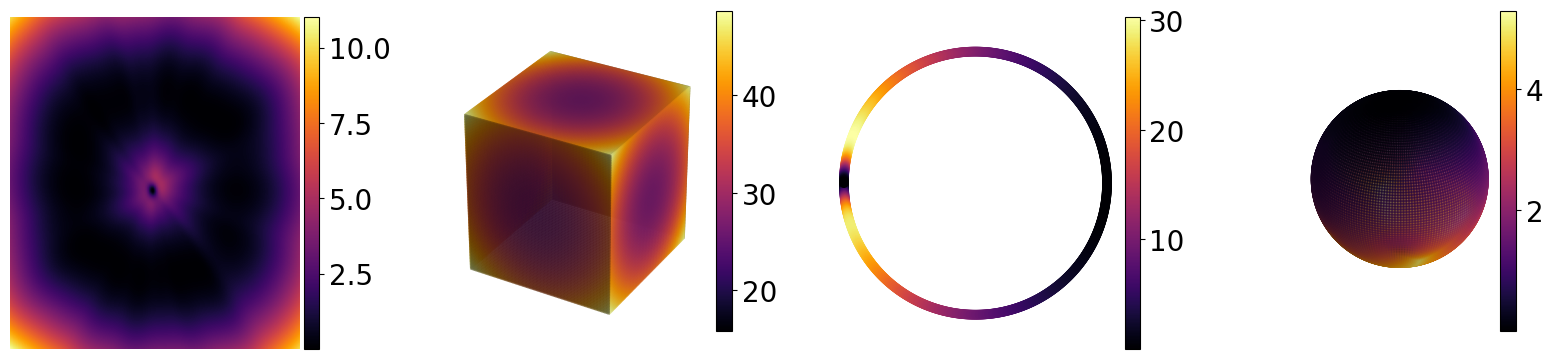

In [20]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_l2, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_l2)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
cbar = fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_l2, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_l2)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[:,:,-1]/jnp.amax(R3_l2[:,:,-1])), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[:,0,:]/jnp.amax(R3_l2[:,0,:])), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[:,-1,:]/jnp.amax(R3_l2[:,-1,:])), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[0,:,:]/jnp.amax(R3_l2[0,:,:])), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[-1,:,:]/jnp.amax(R3_l2[-1,:,:])), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
heat_map = jnp.stack((R3_l2[:,:,0],
                     R3_l2[:,:,-1],
                     R3_l2[:,0,:],
                     R3_l2[:,-1,:],
                     R3_l2[0,:,:],
                     R3_l2[-1,:,:]))
m.set_array(heat_map)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_l2/jnp.amax(S2_l2)), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_l2)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_l2.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


### Plotting Learned Gradient

/tmp/ipykernel_170856/3852196913.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


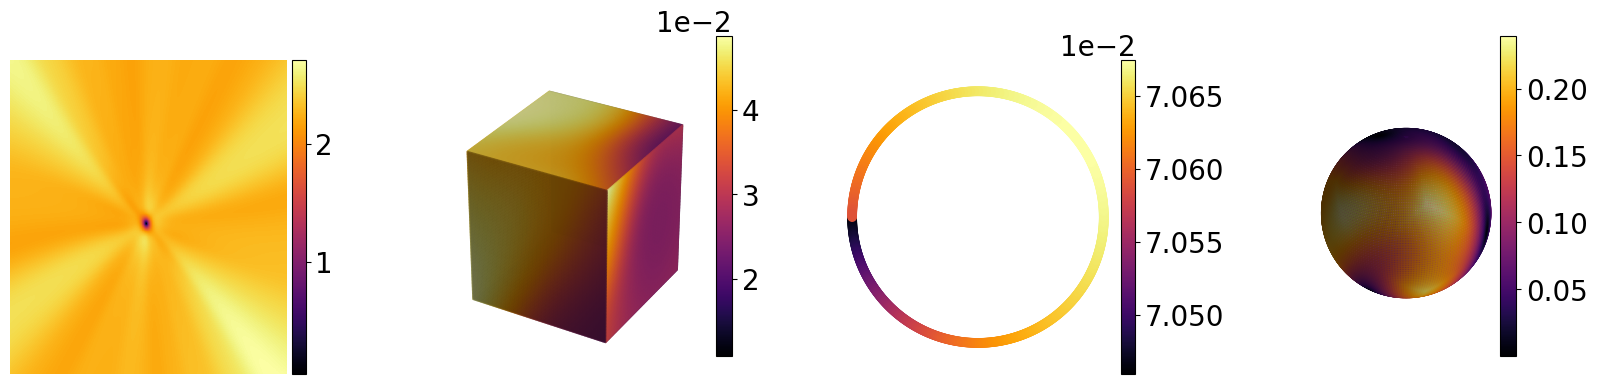

In [21]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_grad, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_grad)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_grad, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_grad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,:,0]/jnp.amax(R3_grad[:,:,0])), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,:,-1]/jnp.amax(R3_grad[:,:,-1])), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,0,:]/jnp.amax(R3_grad[:,0,:])), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,-1,:]/jnp.amax(R3_grad[:,-1,:])), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[0,:,:]/jnp.amax(R3_grad[0,:,:])), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[-1,:,:]/jnp.amax(R3_grad[-1,:,:])), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R3_grad)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_grad/jnp.amax(S2_grad)), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_grad)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_grad.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Synthetic Data Plot

In [67]:
M = nSphere(N=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [68]:
N = 2
file_path = 'scores/S2/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/S2/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Estimating Diffusion t-Mean

In [69]:
xs = pd.read_csv('Data/S2/xs.csv', header=None)
charts = pd.read_csv('Data/S2/chart.csv', header=None)
X_sphere = (jnp.array(xs.values), jnp.array(charts.values))

In [70]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [71]:
musphere_sm, Tsphere_sm, _, _ = M.sm_dmxt(X_sphere, (X_sphere[0][0], X_sphere[1][0]), jnp.array([0.1]), 
                                     step_size=0.01, max_iter=100)

In [72]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_sphere,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_sphere,num_steps=100, N=1)

musphere_bridgex, Tsphere_bridge, musphere_bridgechart = zip(*mu_bridge)
musphere_bridgex, musphere_bridghechart = jnp.stack(musphere_bridgex), jnp.stack(musphere_bridgechart)
Tsphere_bridge = jnp.stack(Tsphere_bridge)

Step 0 | T: 8.987977e+00 | T: ((Array([-0.01236231, -0.02062244], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.931273e+00 | T: ((Array([-0.00264701, -0.0108226 ], dtype=float32), Array(0.21992521, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Final 1 | T: 7.931273e+00 | T: (Array([-0.00264701, -0.0108226 ], dtype=float32), Array(0.21992521, dtype=float32))
Step 0 | T: 8.987884e+00 | T: ((Array([-0.01236231, -0.02062244], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.929206e+00 | T: ((Array([-0.00264605, -0.01082228], dtype=float32), Array(0.2199251, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 7.045866e+00 | T: ((Array([ 0.00650679, -0.00139215], dtype=float32), Array(0.22973487, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 6.303053e+00 | T: ((Array([0.01477957, 0.00747761], dtype=float32), Array(0.23939513, dtype=float32)), Array

Step 52 | T: 1.015454e+00 | T: ((Array([0.01547306, 0.01921712], dtype=float32), Array(0.47655797, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 53 | T: 1.006168e+00 | T: ((Array([0.01498034, 0.01943421], dtype=float32), Array(0.47858316, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 54 | T: 9.971137e-01 | T: ((Array([0.01448303, 0.01957355], dtype=float32), Array(0.48056555, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: 9.888108e-01 | T: ((Array([0.01399652, 0.01963878], dtype=float32), Array(0.48250723, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: 9.813458e-01 | T: ((Array([0.01353078, 0.01963348], dtype=float32), Array(0.48441023, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: 9.729748e-01 | T: ((Array([0.01309579, 0.01956446], dtype=float32), Array(0.48627618, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: 9.656574e-01 | T: ((Array([0.01270133, 0.01943857], dtype=float32), Array(0

In [73]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
musphere_opt, Tsphere_opt, _, _ = M.sm_dmxt(X_sphere, (X_sphere[0][0], X_sphere[1][0]), jnp.array([0.1]))

In [57]:
M = Landmarks(N=2,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())

using M.Exp for Logarithm


In [59]:
file_path = 'scores/Landmarks2/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
file_path_s2 = 'scores/Landmarks2/s2/'
state_s2 = model_loader.load_model(file_path_s2)
layers = [50,100,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):

    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

    return ggrad

def ggrady_log_score(x,y,t):

    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

    return ggrad

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Estimating Diffusion t-Mean

In [60]:
xs = pd.read_csv('Data/Landmarks2/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks2/chart.csv', header=None)
X_landmarks = (jnp.array(xs.values), jnp.array(charts.values))

In [61]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mulandmarks_sm, Tlandmarks_sm, _, _ = M.sm_dmxt(X_landmarks, (X_landmarks[0][0], X_landmarks[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

AttributeError: 'nSphere' object has no attribute 'N'

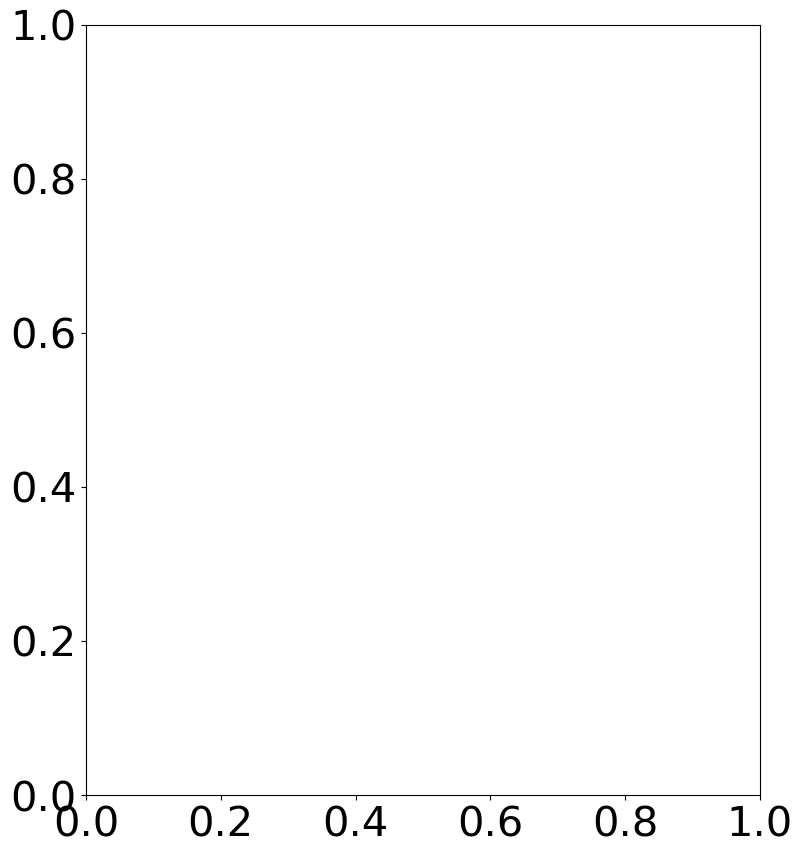

In [74]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(40,10))

#Landmarks
ax = fig.add_subplot(143)
obs = X_landmarks[0].reshape(1000,2,2)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())
for i in range(len(obs)):
    plt.scatter(obs[i][0,0], obs[i][0,1], color='black', alpha=0.2)
    plt.scatter(obs[i][1,0], obs[i][1,1], color='black', alpha=0.2)
plt.scatter(mulandmarks_sm[0][-1].reshape(2,2)[0,0], mulandmarks_sm[0][-1].reshape(2,2)[0,1], color='blue', s=400)
plt.scatter(mulandmarks_sm[0][-1].reshape(2,2)[1,0], mulandmarks_sm[0][-1].reshape(2,2)[1,1], color='blue', s=400)
plt.scatter(x0[0].reshape(2,2)[0,0], x0[0].reshape(2,2)[0,1], color='purple', s=200)
plt.scatter(x0[0].reshape(2,2)[1,0], x0[0].reshape(2,2)[1,1], color='purple', s=200)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(144)
ax.plot(jnp.arange(1,len(Tlandmarks_sm)+1, 1), Tlandmarks_sm, color='blue')
ax.plot(jnp.arange(1,len(Tlandmarks_sm)+1, 1), 0.5*jnp.ones(len(Tlandmarks_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

#S2
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(X_sphere[1][:,0], X_sphere[1][:,1], X_sphere[1][:,2], color='black', alpha=0.2, label='Data')
ax.scatter(musphere_sm[1][-1,0], musphere_sm[1][-1,1], musphere_sm[1][-1,2], color='blue', label='Score Matching', alpha=1.0, s=200)
ax.scatter(musphere_opt[1][-1,0], musphere_opt[1][-1,1], musphere_opt[1][-1,2], color='purple', label='Diffusion t-mean', s=200)
ax.scatter(musphere_bridghechart[-1,0], musphere_bridghechart[1,1], musphere_bridghechart[2,2], color='red', label='Bridge Estimation', s=200)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(142)
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_sm, color='blue')
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_opt[-1]*jnp.ones(len(Tsphere_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Diffusion Variance')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.1), ncol=5)

plt.show()

fig.savefig('Figures/synthetic_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Conceptual Plot

### $\mathbb{S}^{2}$

In [96]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [97]:
file_path = 'scores/S2/s1_'+ loss_type + '/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s2(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_s2(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log_s2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [98]:
N_sim = 5
M = nSphere(N=2)
Brownian_coords(M)

(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0 = M.coords([0.]*2)
x0s = tile(x0, N_sim)

_dts = dts(T=1.0, n_steps=1000)
dW = dWs(N_sim*M.dim,_dts).reshape(-1,N_sim,M.dim)
(ts,xss,chartss,*_) = product(x0s,
                              _dts,dW,jnp.repeat(1.,N_sim))
chartss = vmap(lambda x,y: vmap(lambda x,chart: M.F((x,chart)))(x,y))(xss, chartss)

t = ts[jnp.arange(200,len(ts)+200, 200)]
xs = xss[jnp.arange(200,len(xss)+200, 200)]
chart = chartss[jnp.arange(200,len(chartss)+200, 200)]

using M.Exp for Logarithm


In [99]:
N_sim = 5
M = nSphere(N=2)
Brownian_coords(M)

(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0 = M.coords([0.]*2)
x0s = tile(x0, N_sim)

using M.Exp for Logarithm


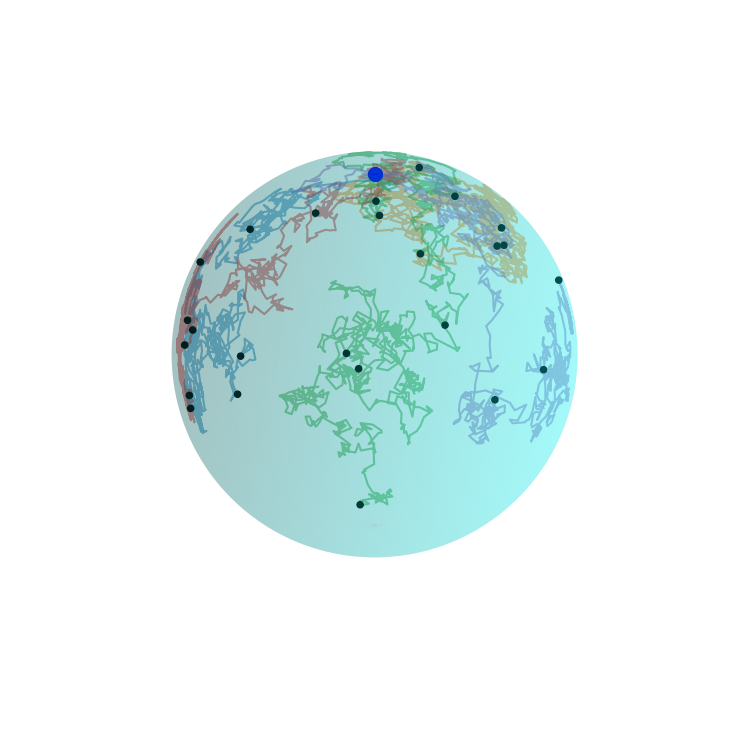

In [100]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_samples.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

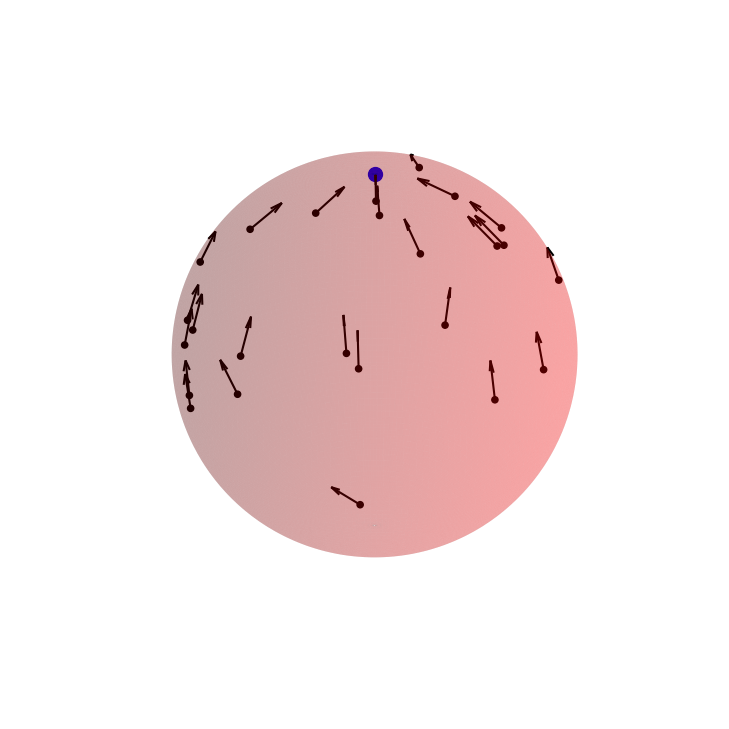

In [101]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

TM_grad_log = vmap(lambda x,chart,t: vmap(lambda x,y: M.grady_log_hk(x0,(x,y),t)[1])(x,chart))(xs,chart,t)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='red', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
ax.quiver(chart[:,:,0], chart[:,:,1], chart[:,:,2], 
          TM_grad_log[:,:,0], TM_grad_log[:,:,1], TM_grad_log[:,:,2], color='black', length=0.2, normalize=True)
#for i in range(N_sim):
#    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_gradients.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Plot Fréchet Mean

### $\mathbb{S}^{2}$

In [102]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [103]:
file_path = 'scores/S2/s1_T/dsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [104]:
from scipy.io import loadmat

sphere_data = loadmat('../../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [105]:
diffusion_mean(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

In [106]:
musm_s2, __ = S2.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.01]), 
                                     step_size=1.0, max_iter=100)

In [107]:
from jaxgeometry.statistics import Frechet_mean
Frechet_mean(S2)

mufrechet_s2,loss,iterations,vs = S2.Frechet_mean(zip(X_obs[0], X_obs[1]),S2_x0)

Step 0 | T: 0.000000e+00 | T: nan
Step 10 | T: nan | T: nan
Step 20 | T: nan | T: nan
Step 30 | T: nan | T: nan
Step 40 | T: nan | T: nan
Step 50 | T: nan | T: nan
Step 60 | T: nan | T: nan
Step 70 | T: nan | T: nan
Step 80 | T: nan | T: nan
Step 90 | T: nan | T: nan
Step 100 | T: nan | T: nan
Step 110 | T: nan | T: nan
Step 120 | T: nan | T: nan
Step 130 | T: nan | T: nan
Step 140 | T: nan | T: nan
Step 150 | T: nan | T: nan
Step 160 | T: nan | T: nan
Step 170 | T: nan | T: nan
Step 180 | T: nan | T: nan
Step 190 | T: nan | T: nan
Step 199 | T: nan | T: nan 


### Torus

In [108]:
M = Torus()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [110]:
file_path = 'scores/Torus/s1_T/dsm/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

FileNotFoundError: [Errno 2] No such file or directory: 'scores/Torus/s1_T/dsm/tree.pkl'

In [77]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [78]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

In [79]:
mu_sm, __ = M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.01]), 
                                     step_size=1.0, max_iter=100)

In [80]:
from jaxgeometry.statistics import Frechet_mean
Frechet_mean(M)

mu_frechet,loss,iterations,vs = M.Frechet_mean(zip(X_obs[0], X_obs[1]),x0)

Step 0 | T: 0.000000e+00 | T: 8.369826e+00
Step 10 | T: 1.258283e+00 | T: 2.138886e+00
Step 20 | T: 1.167032e+00 | T: 2.416724e-01
Step 30 | T: 1.123042e+00 | T: 1.919807e-01
Step 40 | T: 9.799383e-01 | T: 2.004060e-01
Step 50 | T: 9.910663e-01 | T: 5.876143e-02
Step 60 | T: 1.000769e+00 | T: 6.419628e-02
Step 70 | T: 9.988730e-01 | T: 3.578848e-02
Step 80 | T: 9.744833e-01 | T: 3.145772e-02
Step 90 | T: 9.896396e-01 | T: 2.188000e-02
Step 100 | T: 9.936963e-01 | T: 1.557699e-02
Step 110 | T: 9.887246e-01 | T: 1.588880e-02
Step 120 | T: 9.818046e-01 | T: 6.365098e-03
Step 130 | T: 9.800748e-01 | T: 1.064173e-02
Step 140 | T: 9.865332e-01 | T: 2.043733e-03
Step 150 | T: 9.858813e-01 | T: 5.701423e-03
Step 160 | T: 9.832497e-01 | T: 1.695973e-03
Step 170 | T: 9.810843e-01 | T: 2.588808e-03
Step 180 | T: 9.829767e-01 | T: 1.371845e-03
Step 190 | T: 9.842321e-01 | T: 1.038445e-03
Step 199 | T: 9.838590e-01 | T: 1.096530e-03 


In [81]:
Xobs_torus = vmap(lambda x1,x2: M.F((x1,x2)))(X_obs[0], X_obs[1])
musm_torus = vmap(lambda x1,x2: M.F((x1,x2)))(mu_sm[0], mu_sm[1])
mufrechet_torus = M.F(mu_frechet)

### Cylinder

In [111]:
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [112]:
file_path = 'scores/Cylinder/s1_T/dsm/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

FileNotFoundError: [Errno 2] No such file or directory: 'scores/Cylinder/s1_T/dsm/tree.pkl'

In [113]:
xs = pd.read_csv('Data/Cylinder/xs.csv', header=None)
charts = pd.read_csv('Data/Cylinder/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [114]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

AttributeError: 'function' object has no attribute 'initialize'

In [115]:
mu_sm, __ = M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.01]), 
                                     step_size=1.0, max_iter=100)

AttributeError: 'Cylinder' object has no attribute 'sm_dmx'

In [116]:
from jaxgeometry.statistics import Frechet_mean
Frechet_mean(M)

mu_frechet,loss,iterations,vs = M.Frechet_mean(zip(X_obs[0], X_obs[1]),x0)

Step 0 | T: 0.000000e+00 | T: 2.101420e+01
Step 10 | T: 9.021190e-01 | T: 8.629092e+00
Step 20 | T: 1.285974e+00 | T: 3.185791e+00
Step 30 | T: 1.125498e+00 | T: 5.821892e-01
Step 40 | T: 1.011828e+00 | T: 2.435212e-01
Step 50 | T: 1.016566e+00 | T: 1.088962e-01
Step 60 | T: 1.030019e+00 | T: 9.044576e-02
Step 70 | T: 1.033641e+00 | T: 6.554155e-02
Step 80 | T: 1.015054e+00 | T: 5.635281e-02
Step 90 | T: 1.032660e+00 | T: 3.189034e-02
Step 100 | T: 1.020949e+00 | T: 3.693931e-02
Step 110 | T: 1.021222e+00 | T: 2.310714e-02
Step 120 | T: 1.014831e+00 | T: 1.967280e-02
Step 130 | T: 1.013408e+00 | T: 1.479642e-02
Step 140 | T: 1.018988e+00 | T: 8.725167e-03
Step 150 | T: 1.013577e+00 | T: 8.862250e-03
Step 160 | T: 1.012260e+00 | T: 4.944273e-03
Step 170 | T: 1.011208e+00 | T: 4.744217e-03
Step 180 | T: 1.013663e+00 | T: 2.415291e-03
Step 190 | T: 1.012889e+00 | T: 2.282438e-03
Step 199 | T: 1.012012e+00 | T: 1.601880e-03 


In [117]:
Xobs_cylinder = vmap(lambda x1,x2: M.F((x1,x2)))(X_obs[0], X_obs[1])
musm_cylinder = vmap(lambda x1,x2: M.F((x1,x2)))(mu_sm[0], mu_sm[1])
mufrechet_cylinder = M.F(mu_frechet)

NameError: name 'mu_sm' is not defined

### Plot Fréchet Mean

In [ ]:
import numpy as np

plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(30,10))

#Landmarks
ax = fig.add_subplot(131, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(musm_s2[1][-1,0], musm_s2[1][-1,1], musm_s2[1][-1,2], color='blue', alpha=1.0, s=500, label='Score Matching')
ax.scatter(mufrechet_s2[1][0], mufrechet_s2[1][1], mufrechet_s2[1][2], color='purple', alpha=1.0, s=500, label='Fréchet Mean')
ax.scatter(Xobs_s2[1][:,0], Xobs_s2[1][:,1], Xobs_s2[1][:,2], color='black', alpha=0.2, label='Data')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

# Creating the theta and phi values.
M = Torus()
u, v = np.mgrid[-np.pi:np.pi:40j, -np.pi:np.pi:20j]
x = np.zeros(u.shape)
y = np.zeros(u.shape)
z = np.zeros(u.shape)
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        w = M.F(M.coords(jnp.array([u[i,j],v[i,j]])))
        x[i,j] = w[0]; y[i,j] = w[1]; z[i,j] = w[2]
#rot_mat = lambda v: jnp.array([[1.0, 0.0, 0.0],
#                     [0.0, jnp.cos(v), -jnp.sin(v)],
#                    [0.0, jnp.sin(v), -jnp.cos(v)]])
#X_circle = jnp.vstack((X_circle[0].reshape(1,-1),
#                       jnp.array([-X_circle[0][0], -X_circle[0][1], X_circle[0][2]]).reshape(1,-1))) #delete this

#X_circle = jnp.vstack((jnp.array([1.0, 0.0, 0.0]).reshape(1,-1),
#                      jnp.array([0.0, 1.0, 0.0]).reshape(1,-1)))
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(Xobs_torus[:,0], Xobs_torus[:,1], Xobs_torus[:,2], alpha=0.2, color='black')
ax.plot_wireframe(x, y, z, color='gray', alpha=0.5)
ax.scatter(musm_torus[:,0], musm_torus[:,1], musm_torus[:,2], color='blue', s=500)
ax.scatter(mufrechet_torus[0], mufrechet_torus[1], mufrechet_torus[2], color='purple', s=500)
ax.set_box_aspect([1,1,1])
ax.set_axis_off()
ax.view_init(0, 20)

ax = fig.add_subplot(133, projection='3d')
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
#https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z, N_points=100):
    z = jnp.linspace(-height_z, height_z, N_points)
    theta = jnp.linspace(0, 2*jnp.pi, N_points)
    theta_grid, z_grid= jnp.meshgrid(theta, z)
    x_grid = radius*jnp.cos(theta_grid) + center_x
    y_grid = radius*jnp.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
Xc,Yc,Zc = data_for_cylinder_along_z(0.0,0.0,1.0,4.0)
ax.plot_surface(Xc, Yc, Zc, cstride=1, alpha=0.5)
ax.scatter(Xobs_cylinder[:,0], Xobs_cylinder[:,1], Xobs_cylinder[:,2], alpha=0.2, color='black')
ax.scatter(musm_cylinder[:,0], musm_cylinder[:,1], musm_cylinder[:,2], s=500, color='blue')
ax.scatter(mufrechet_cylinder[0], mufrechet_cylinder[1], mufrechet_cylinder[2], s=500, color='purple')
ax.set_box_aspect([1,1,1])
ax.set_axis_off()
ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
ax.view_init(-140, 270)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.2), ncol=5)

plt.show()

fig.savefig('Figures/frechet_plot.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Plot Diffusion Mean

## Landmarks

In [121]:
N_sample = 50
N_half = N_sample // 2

In [122]:
data = pd.read_csv('../../../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [123]:
with open('../../../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [124]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)
    idx = jnp.round(np.linspace(0, len(data1) - 1, N_sample)).astype(int)
    landmark_data.append(jnp.vstack((data1[idx], data2[idx])).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [125]:
import glob

#%% Hyper-parameters

n = 66
d = 2

files = glob.glob("../../../../../Data/landmarks/cardiac/*.asf")
K = len(files)

qs = jnp.zeros((K,n,d))
for j in range(K):
    try:
        in_file = open(files[j], 'r')

        NN = -1
        for line in in_file.readlines():
            if len(line) > 1 and line[0] != '#':
                splits = line.split()
                if NN < 0 and len(splits) == 1:
                    NN = int(splits[0])
                    q = jnp.zeros((n,d))
                    i = 0
                if len(splits) >= 7:
                    q = q.at[i,0].set(float(splits[2]))
                    q = q.at[i,1].set(float(splits[3]))
                    i = i + 1 
    finally:
        in_file.close()
    qs = qs.at[j].set(q-jnp.tile(jnp.mean(q,axis=0),((q.shape[0],1))))


In [126]:
idx = jnp.round(np.linspace(0, qs.shape[1] - 1, N_sample)).astype(int)
landmark_data = qs[:,idx].reshape(qs.shape[0],-1)*1000

In [127]:
M = Landmarks(N=N_sample,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

using M.Exp for Logarithm


In [128]:
file_path = 'scores/Landmarks'+str(N_sample)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
if 2*N_sample<10:
    layers = [50,100,100,50]
elif 2*N_sample<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [129]:
X_obs = (landmark_data, jnp.zeros(len(landmark_data)))
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="JAX")
mulandmark_sm, Tlandmark_sm, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                             max_iter=1000)

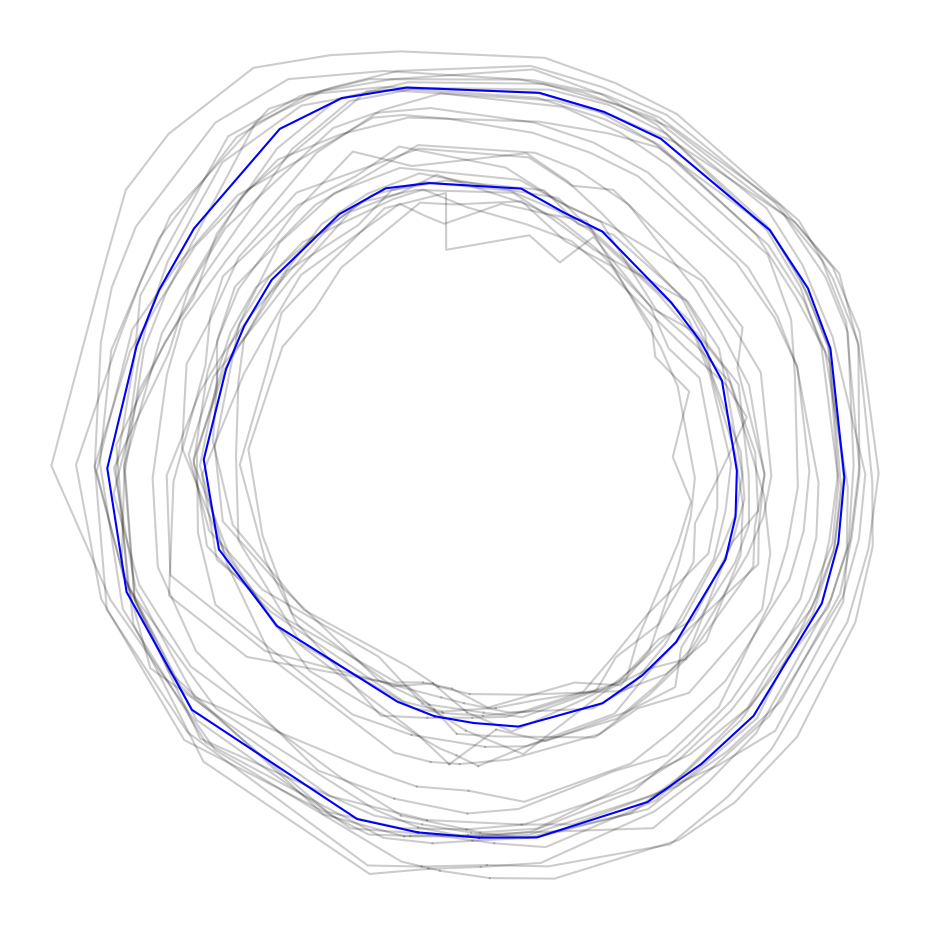

In [130]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
mu = mulandmark_sm[0][-1].reshape(-1,2)
for wing in landmark_data:
    wing = wing.reshape(-1,2)
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

## MNIST

In [131]:
from scipy import ndimage

from gp.gp import RM_EG
from jaxgeometry.manifolds import LearnedManifold

import tensorflow_datasets as tfds

from typing import NamedTuple

from jax import Array

ModuleNotFoundError: No module named 'gp'

In [43]:
class Batch(NamedTuple):
    image: Array  # [B, H, W, C]x

def load_mnist(split: str, batch_size: int, seed: int):
  ds = (
      tfds.load("mnist", split=split)
      .shuffle(buffer_size=10 * batch_size, seed=seed)
      .batch(batch_size)
      .prefetch(buffer_size=5)
      .repeat()
      .as_numpy_iterator()
  )
  return map(lambda x: Batch(x["image"]/255), ds)

In [44]:
default_omega = 500.
def k_fun(x,y, beta=1.0, omega=default_omega):
    
    x_diff = x-y

    return beta*jnp.exp(-omega*jnp.dot(x_diff, x_diff)/2)

def Dk_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = y-x

    return omega*x_diff*k_fun(x,y,beta,omega)

def DDk_fun(x,y, beta=1.0, omega=default_omega):

    N = len(x)
    x_diff = (x-y).reshape(1,-1)

    return -omega*k_fun(x,y,beta,omega)*(x_diff.T.dot(x_diff)*omega-jnp.eye(N))

In [45]:
s1_path = ''.join(('scores/MNIST/',loss_type,'/'))
if loss_type == "T":
    loss_type = 'vsm'
s2_path = 'scores/MNIST/s2/'

data_generator = load_mnist('train[:80%]', 100, 2712)
img_base = next(data_generator).image[0]

num_rotate = 200
theta = jnp.linspace(0,2*jnp.pi,num_rotate)
x1 = jnp.cos(theta)
x2 = jnp.sin(theta)

theta_degrees = theta*180/jnp.pi

rot = []
for v in theta_degrees:
    rot.append(ndimage.rotate(img_base, v, reshape=False))
rot = jnp.stack(rot)/255

rot = jnp.load('Data/MNIST/rot.npy')

2023-12-05 16:58:42.234260: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [46]:
sigman = 0.0
X_training = jnp.vstack((x1,x2))
y_training = rot.reshape(num_rotate, -1).T
RMEG = RM_EG(X_training, y_training, sigman=sigman, k_fun=k_fun, Dk_fun = Dk_fun, DDk_fun = DDk_fun, delta_stable=1e-10)

g = lambda x: RMEG.G(x[0])

M = LearnedManifold(g,N=2)

Brownian_coords(M)

N_dim = M.dim

x0 = M.coords(jnp.array([jnp.cos(0.), jnp.sin(0.)]))

layers = [50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=N_dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                            dim=N_dim, r = max(N_dim//2,1))(x))

data_generator = lambda : xgenerator(M, 
                                    product,
                                    x_samples=x_samples,
                                    t_samples=t_samples,
                                    N_sim = N_sim,
                                    max_T = max_T, 
                                    dt_steps = dt_steps)
update_coords = lambda Fx: update_xcoords(M, Fx)
proj_grad = lambda s1, x0, x, t: proj_gradx(s1, x0, x,t)
proj_hess = lambda s1, s2, x0, x, t: proj_hessx(s1, s2, x0, x, t)

using M.Exp for Logarithm


2023-12-05 16:58:44.391428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [47]:
N_points = 1000
min_x = -2.0
max_x = 2.0
x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)
X1_R2, X2_R2 = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_R2.reshape(1, N_points, N_points), 
                     X2_R2.reshape(1, N_points, N_points))), axes=(1,2,0))

test = vmap(lambda x: vmap(lambda y: RMEG.post_mom(y))(x))(X_heat)

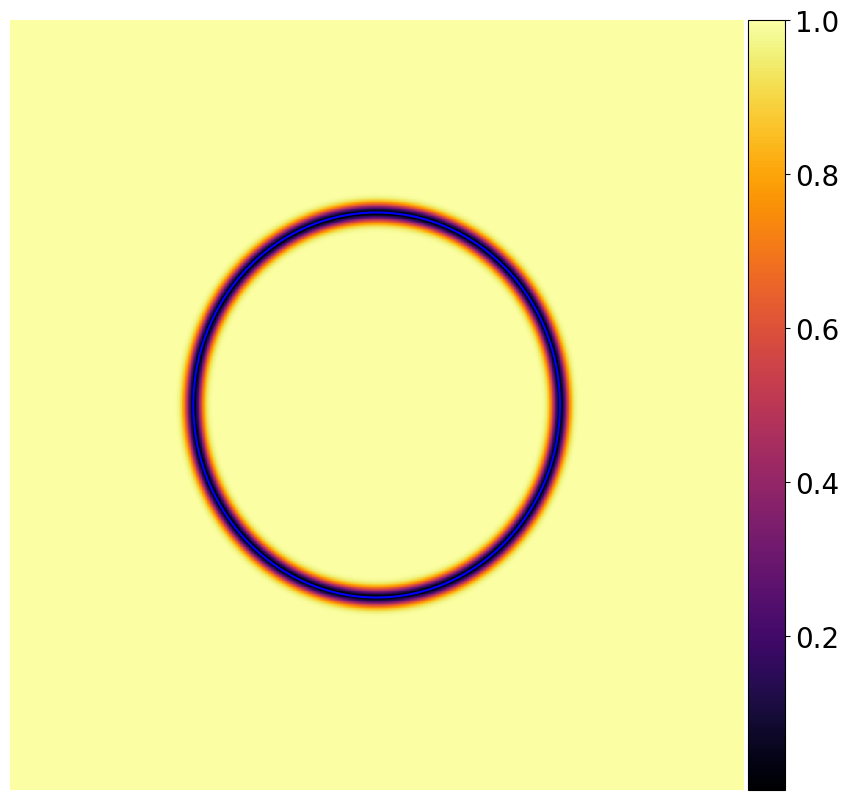

In [48]:
fig = plt.figure(figsize=(10,10))

#R2
ax = fig.add_subplot(111)
ax.imshow(test[1].reshape(1000,1000), cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
ax.plot(X_training[0], X_training[1], color='blue')
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(test[1].reshape(1000,1000))
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)


In [49]:
file_path = 'scores/MNIST/'+ loss_type + '/'
state = model_loader.load_model(file_path)
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [50]:
test = jnp.load('scores/MNIST/'+ loss_type + '/loss_arrays.npy')
test.shape

(72,)

In [51]:
X_obs = (X_training[:,:len(rot)//2].T, jnp.zeros(len(rot)//2).reshape(-1,1))

In [52]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mulandmark_mnist, Tlandmark_mnist, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                             step_size=0.1, max_iter=1000)

In [53]:
test = RMEG.post_mom(mulandmark_mnist[0][-1])[0]

In [54]:
data_post = vmap(lambda x: RMEG.post_mom(x)[0])(X_obs[0])

In [55]:
data_post.shape

(100, 784, 1)

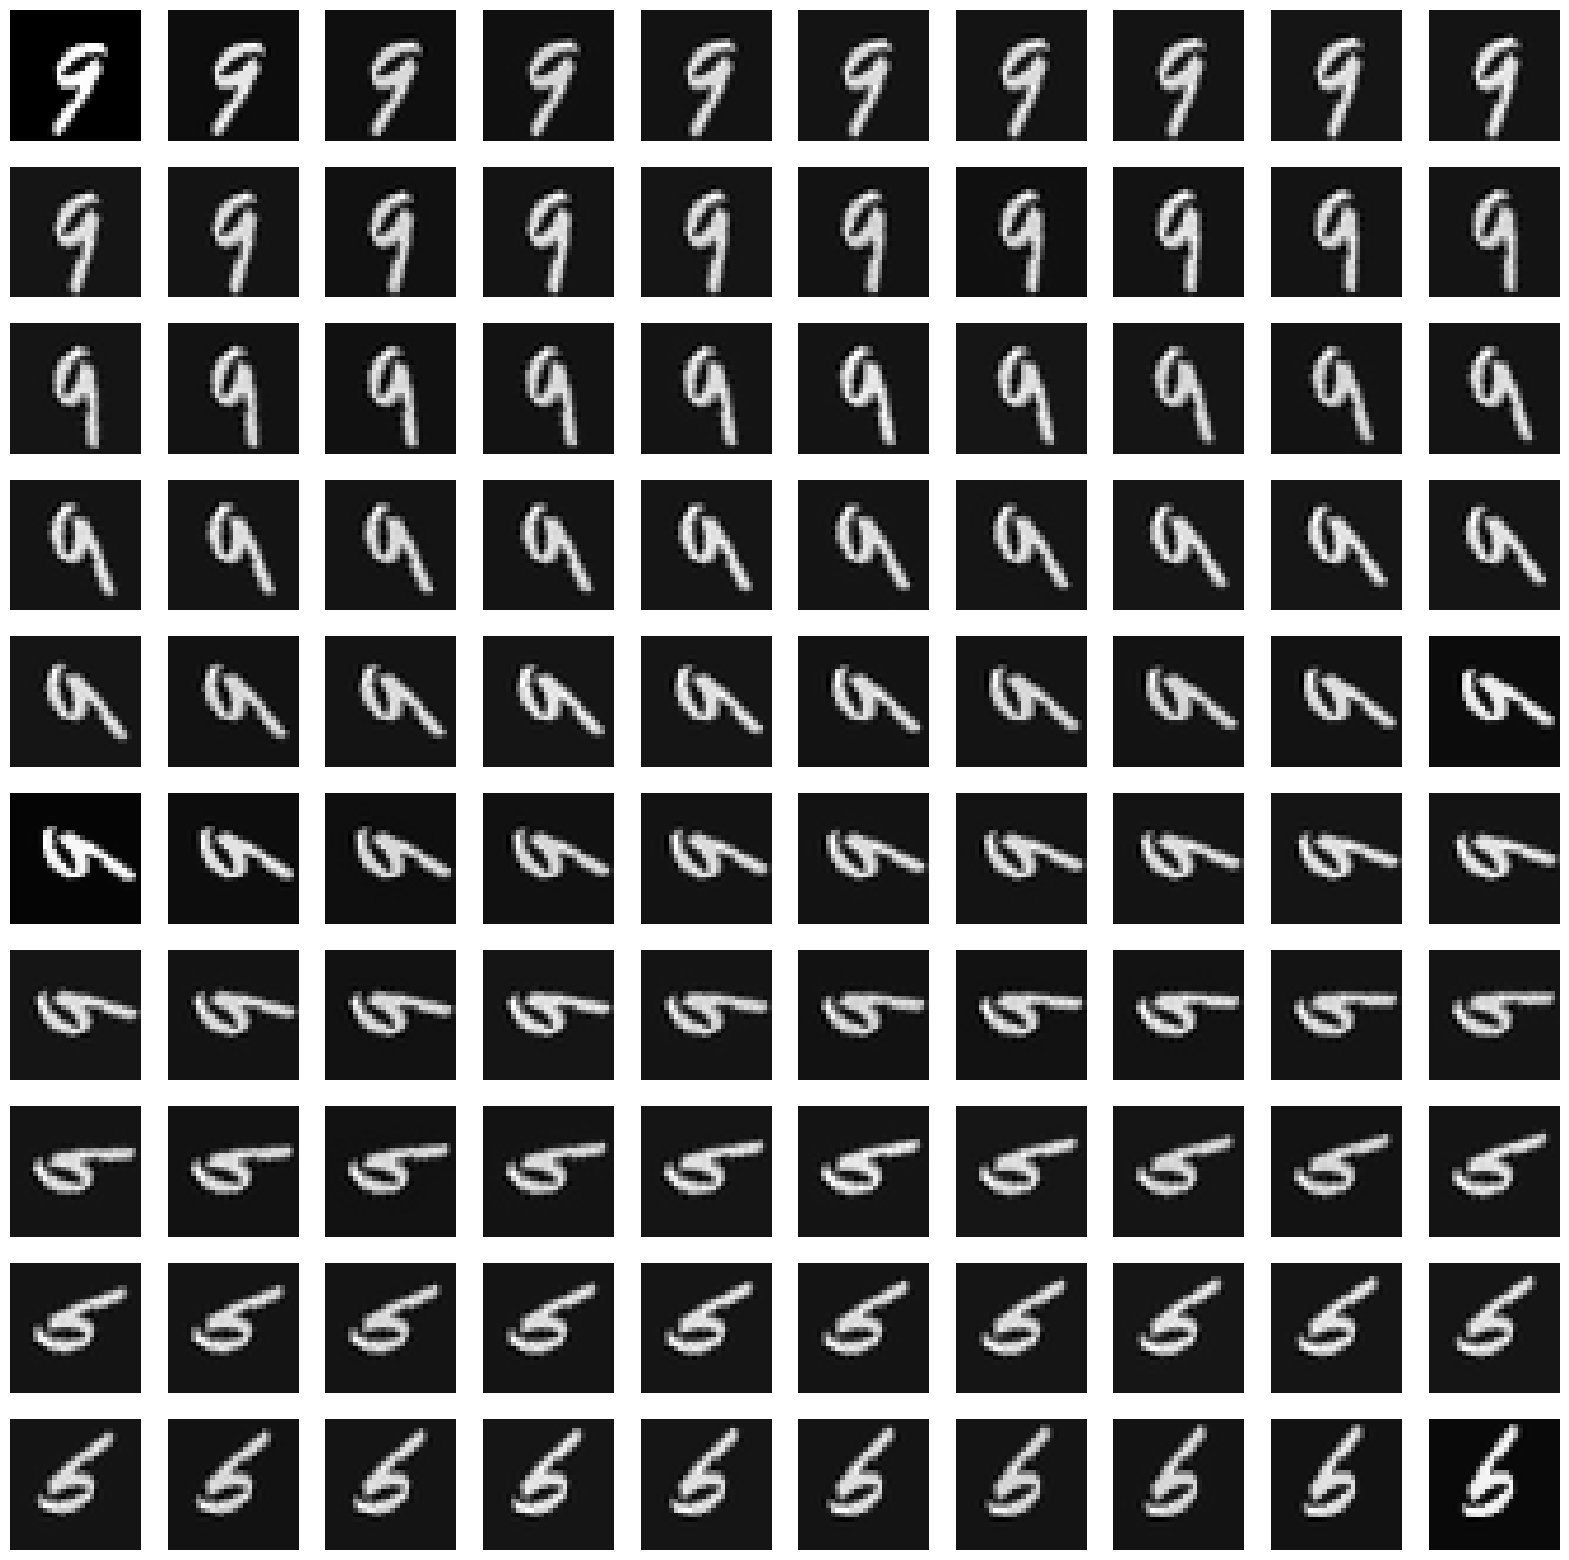

In [56]:
fig = plt.figure(figsize=(20,20))
i = 0
for img in data_post:
    ax = fig.add_subplot(10,10,i+1)
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_axis_off()
    i += 1

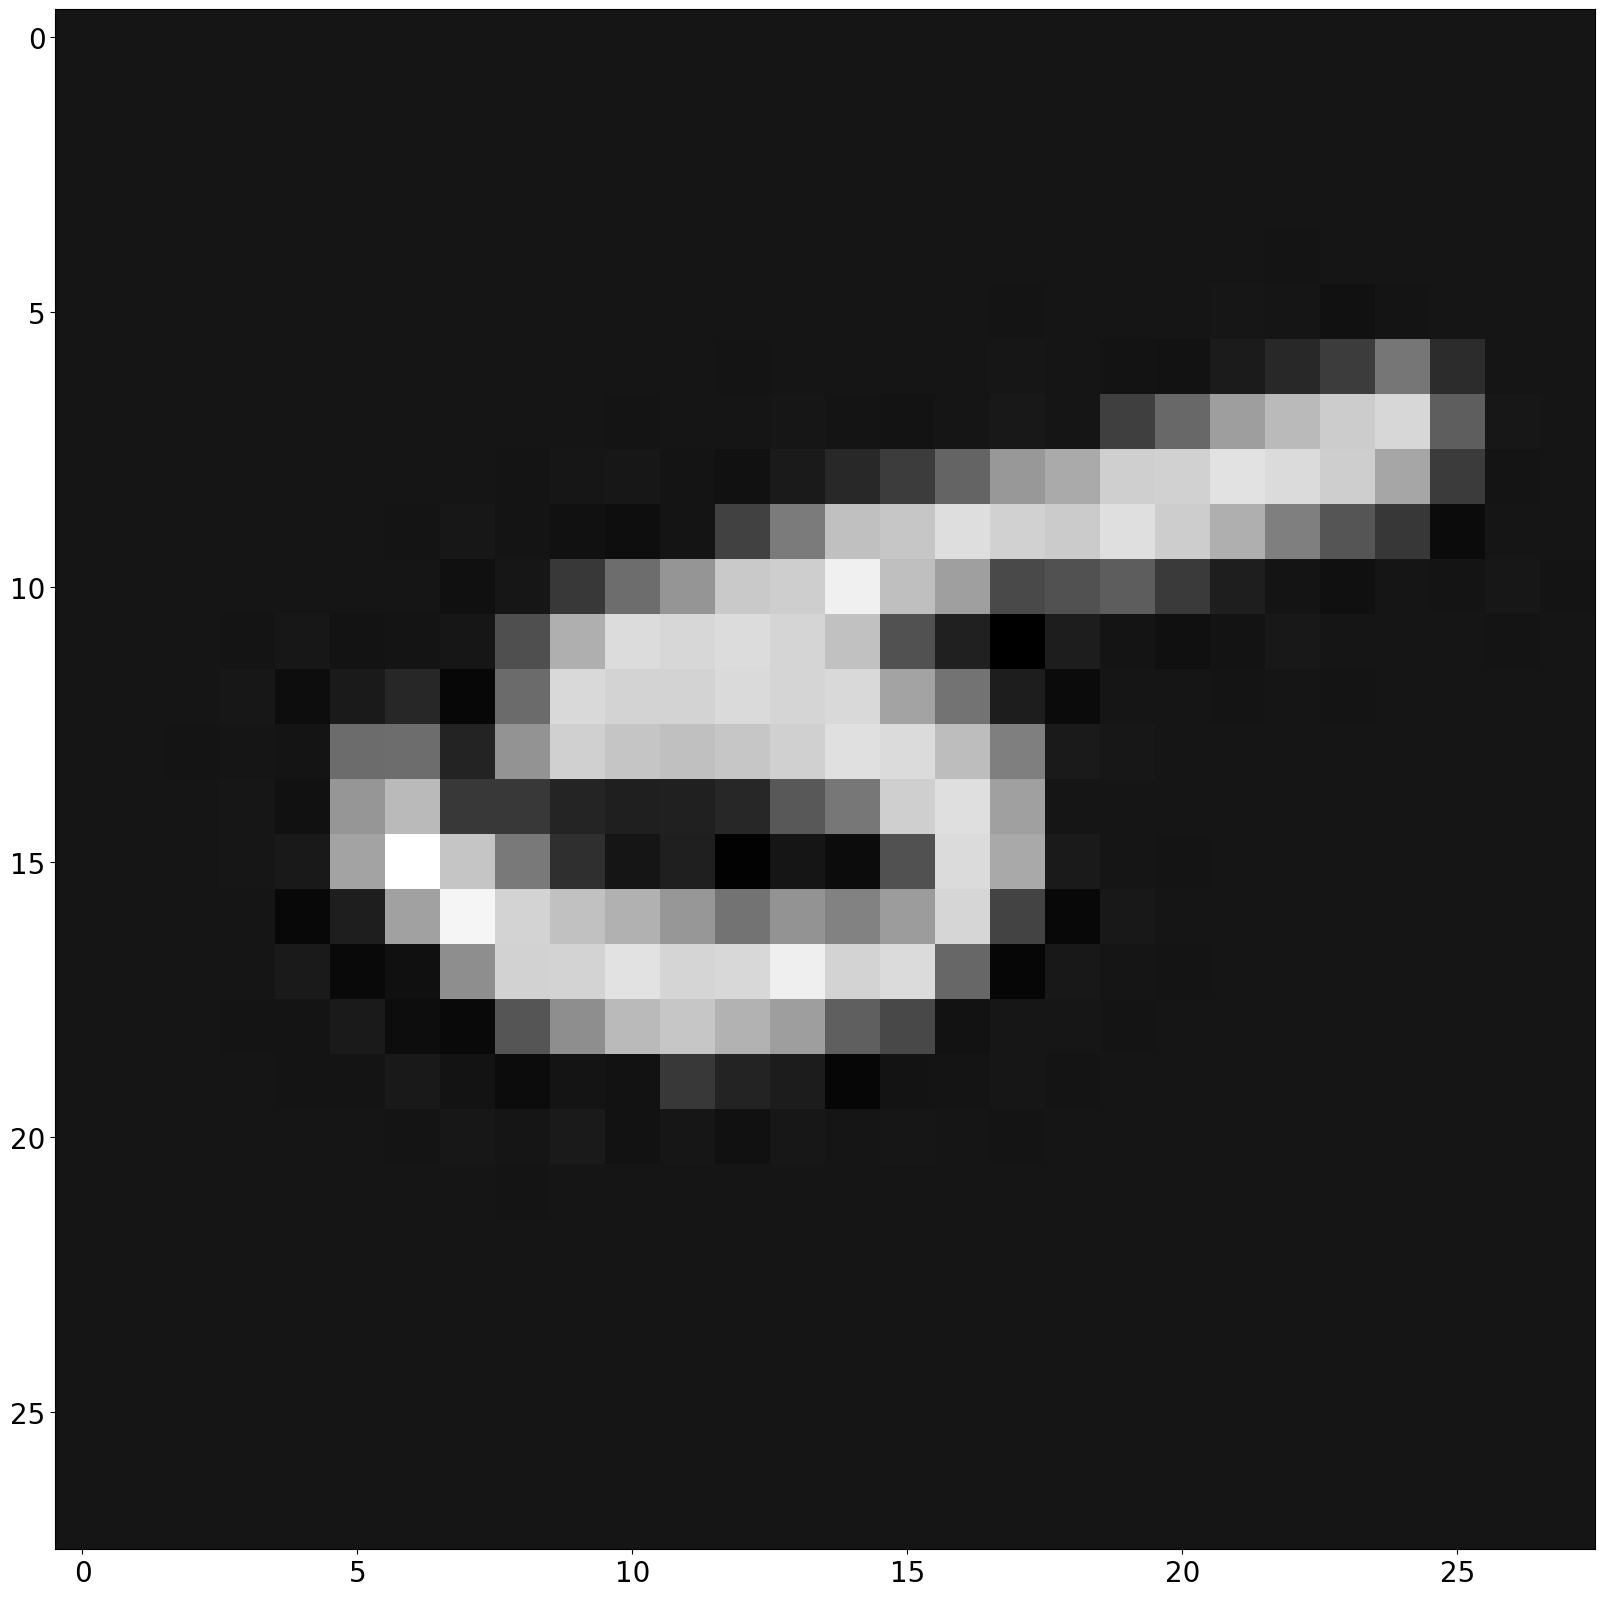

In [57]:
fig = plt.figure(figsize=(20,20))
test = RMEG.post_mom(mulandmark_mnist[0][-1])[0]
ax = fig.add_subplot(111)
ax.imshow(test.reshape(28,28), cmap='gray')

## SPDN

In [132]:
N = 10

In [133]:
M = SPDN(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [134]:
file_path = 'scores/SPDN'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
from jax import jacfwd
if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [135]:
spdn_data = vmap(lambda x: jnp.eye(10)*x)(jnp.linspace(5,15,100))
X_obs = vmap(lambda x: get_coords(M, x.reshape(-1)))(spdn_data)

In [136]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
muspdn_sm, Tspdn_sm, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                             step_size=0.1, max_iter=100)

/home/fmry/anaconda3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


### $\mathbb{S}^{2}$

In [137]:
N = 2
M = nSphere(N=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [138]:
file_path = 'scores/S'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

In [139]:
from scipy.io import loadmat

sphere_data = loadmat('../../../../../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
Xsphere_obs = vmap(lambda chart: get_coords(M, chart))(charts)


In [140]:
import pandas as pd

data = pd.read_csv('../../../../../Data/S2/transits.csv', sep='%')
data[['phi','theta']] = data['Unnamed: 0'].str.split(',',expand=True)
data['phi'] = data['phi'].astype('float')
data['theta'] = data['theta'].astype('float')

phi = jnp.array(data['phi'])
theta = jnp.array(data['theta'])

charts = jnp.array([jnp.cos(phi)*jnp.sin(theta),
                   jnp.sin(phi)*jnp.sin(theta),
                   jnp.cos(theta)]).T

charts = charts[charts[:,2]<0.]

Xsphere_obs = vmap(lambda chart: get_coords(M, chart))(charts)


In [141]:
import pandas as pd

data = pd.read_csv('../../../../../Data/S2/image_data.csv', sep=',')

Xsphere_obs = vmap(lambda chart: get_coords(M, chart))(charts)


In [142]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [143]:
musphere_sm, Tsphere_sm, _, _ = M.sm_dmxt(Xsphere_obs, (Xsphere_obs[0][0], Xsphere_obs[1][0]), jnp.array([0.2]), 
                                         step_size=0.1, max_iter=1000)

In [144]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
musphere_opt, Tsphere_opt, _, _ = M.sm_dmxt(Xsphere_obs, (Xsphere_obs[0][0], Xsphere_obs[1][0]), jnp.array([0.1]))

In [145]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [146]:
file_path = 'scores/S2/s1_dsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [147]:
from scipy.io import loadmat

sphere_data = loadmat('../../../../../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [148]:
import pandas as pd
N = 1000

data = pd.read_csv('../../../../../Data/S2/image_data.csv', sep=',')
data = jnp.array(data)
idx = np.round(np.linspace(0, len(data) - 1, N)).astype(int)
data = data[idx]
X_obs = vmap(lambda chart: get_coords(M, chart))(jnp.array(data))


In [149]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])
dist_fun = lambda x,y,t=0.1: jnp.arccos(jnp.dot(x[1],y[1]))

In [150]:
diffusion_mean(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

#def frechet_fun(X_obs, X_init, t=0.1):
    
#    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
#    return (mu[0][-1], mu[1][-1])

def frechet_fun(X_obs, X_init, t=0.1):
    
    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [151]:
from jaxgeometry.statistics.score_matching import kmeans

In [152]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=5, max_iter = 100)

In [153]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

AttributeError: module 'random' has no attribute 'split'

In [406]:
centroidseuc_s2, centroideuc_idxs_s2 = RMK.centroids, RMK.centroid_idx

In [407]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [408]:
file_path = 'scores/S2/vsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [409]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [410]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

def frechet_fun(X_obs, X_init, t=0.1):
    
    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.01, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

#def frechet_fun(X_obs, X_init, t=0.01):
    
#    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [411]:
from jaxgeometry.statistics.score_matching import kmeans

In [412]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=5, max_iter = 100)

In [413]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

In [414]:
centroidssm_s2, centroidsm_idxs_s2 = RMK.centroids, RMK.centroid_idx

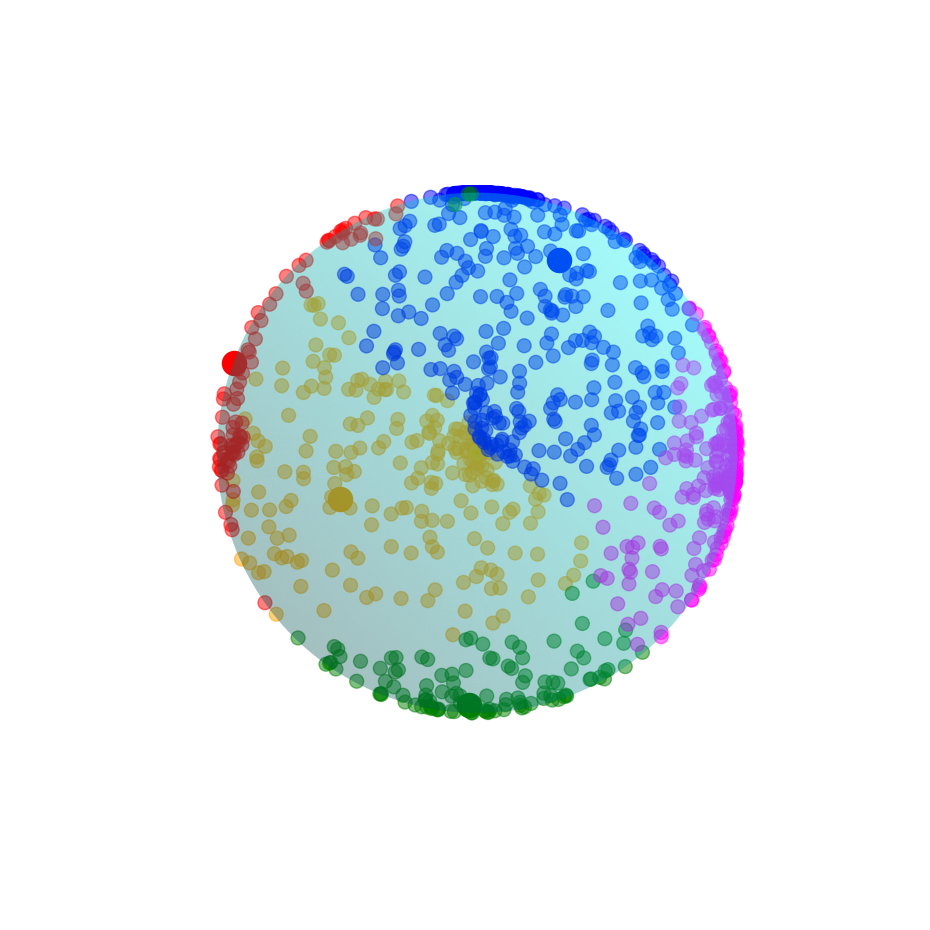

In [415]:
color = ['magenta', 'red', 'green', 'orange', "blue"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(centroidssm_s2[1][:,0], centroidssm_s2[1][:,1], centroidssm_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
j = 0
for center in centroidssm_s2[1]:
    ax.scatter(center[0], center[1], center[2], color=color[j], alpha=1.0, s=300, label='Centroids')
    j += 1

for i in range(len(centroidsm_idxs_s2)):
    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
               X_obs[1][centroidsm_idxs_s2[i],1], 
               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.5, s=100, color=color[i], label='Cluser ' + str(i+1))

#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=90, azim=270)
fig.tight_layout()

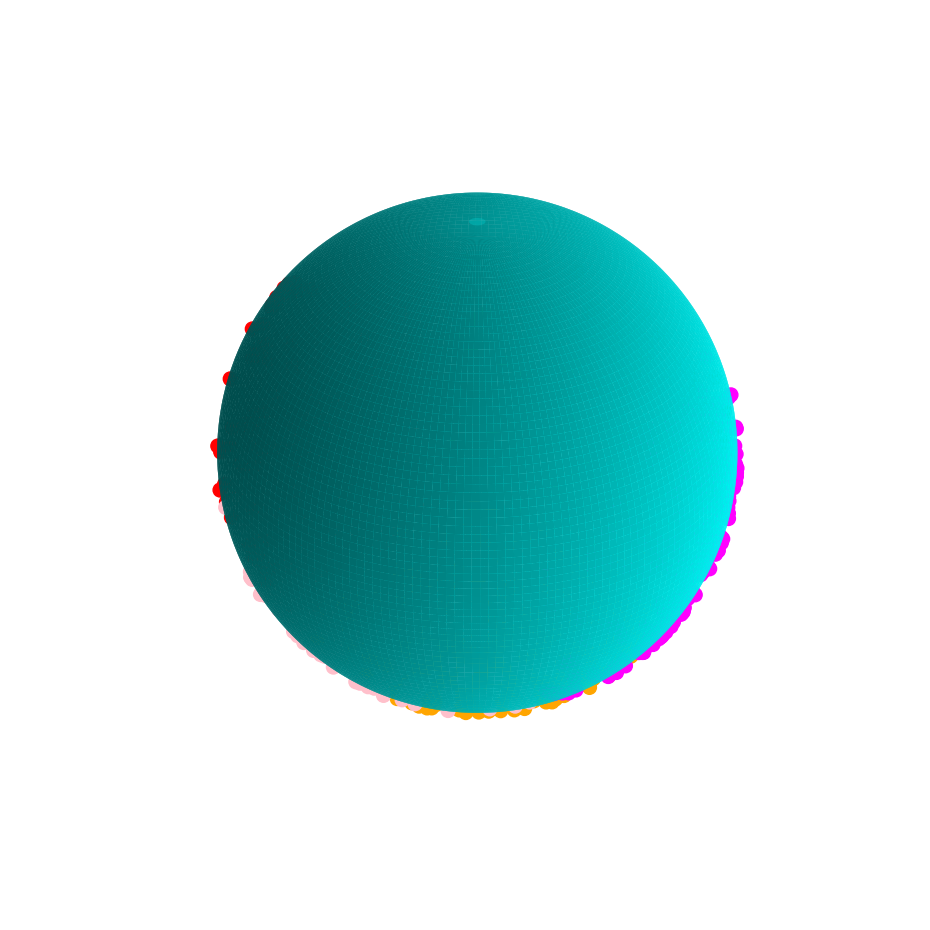

In [416]:
color = ['magenta', 'red', 'green', 'orange', "pink"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=1.0)
#ax.scatter(centroidssm_s2[1][:,0], centroidssm_s2[1][:,1], centroidssm_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
j = 0
for center in centroidseuc_s2[1]:
    ax.scatter(center[0], center[1], center[2], color=color[j], alpha=1.0, s=300, label='Centroids')
    j += 1

for i in range(len(centroideuc_idxs_s2)):
    ax.scatter(X_obs[1][centroideuc_idxs_s2[i],0], 
               X_obs[1][centroideuc_idxs_s2[i],1], 
               X_obs[1][centroideuc_idxs_s2[i],2], alpha=1.0, s=100, color=color[i], label='Cluser ' + str(i+1))

#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

In [72]:
val = []
for j in range(len(centroidsm_idxs_s2)):
    for i in range(len(centroideuc_idxs_s2)):
        cluster1 = X_obs[1][centroideuc_idxs_s2[i]]
        cluster2 = X_obs[1][centroidsm_idxs_s2[j]]
        max_c1 = jnp.max(vmap(lambda c: jnp.min(jnp.linalg.norm(cluster1-c, axis=1)))(cluster2))
        max_c2 = jnp.max(vmap(lambda c: jnp.min(jnp.linalg.norm(cluster2-c, axis=1)))(cluster1))
        val.append(max(max_c1,max_c2))
        
print(val)
print(max(val))

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 104591431440 bytes.

In [59]:
import os
import imageio
path = '../../../../../Data/landmarks/cardiac/'
cardiac_image= imageio.imread(os.path.join(path,'c4480h_s1.png'))

import scipy as sp

def crop(image, x1, x2, y1, y2):
    """
    Return the cropped image at the x1, x2, y1, y2 coordinates
    """
    if x2 == -1:
        x2=image.shape[1]-1
    if y2 == -1:
        y2=image.shape[0]-1

    mask = np.zeros(image.shape)
    mask[y1:y2+1, x1:x2+1]=1
    m = mask>0

    return image[m].reshape((y2+1-y1, x2+1-x1))

cardiac_image = crop(cardiac_image, 90, 175, 80, 160)

/tmp/ipykernel_492570/862055378.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  cardiac_image= imageio.imread(os.path.join(path,'c4480h_s1.png'))


## Plotting

ValueError: axes don't match array

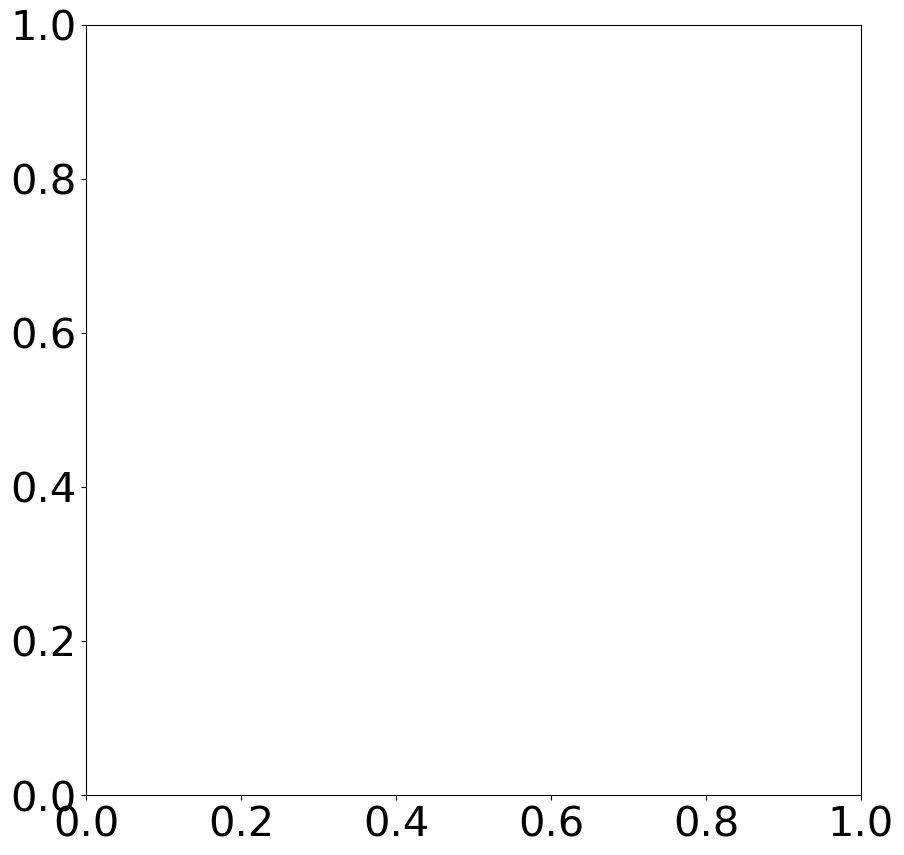

In [137]:
import torch
import torchvision.utils as vutils

mnist_data = torch.Tensor(np.array(data_post.reshape(-1,1,28,28)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(np.transpose(vutils.make_grid(mnist_data.to('cpu'), padding=2, normalize=True, nrow=10).cpu(),(1,2,0)))

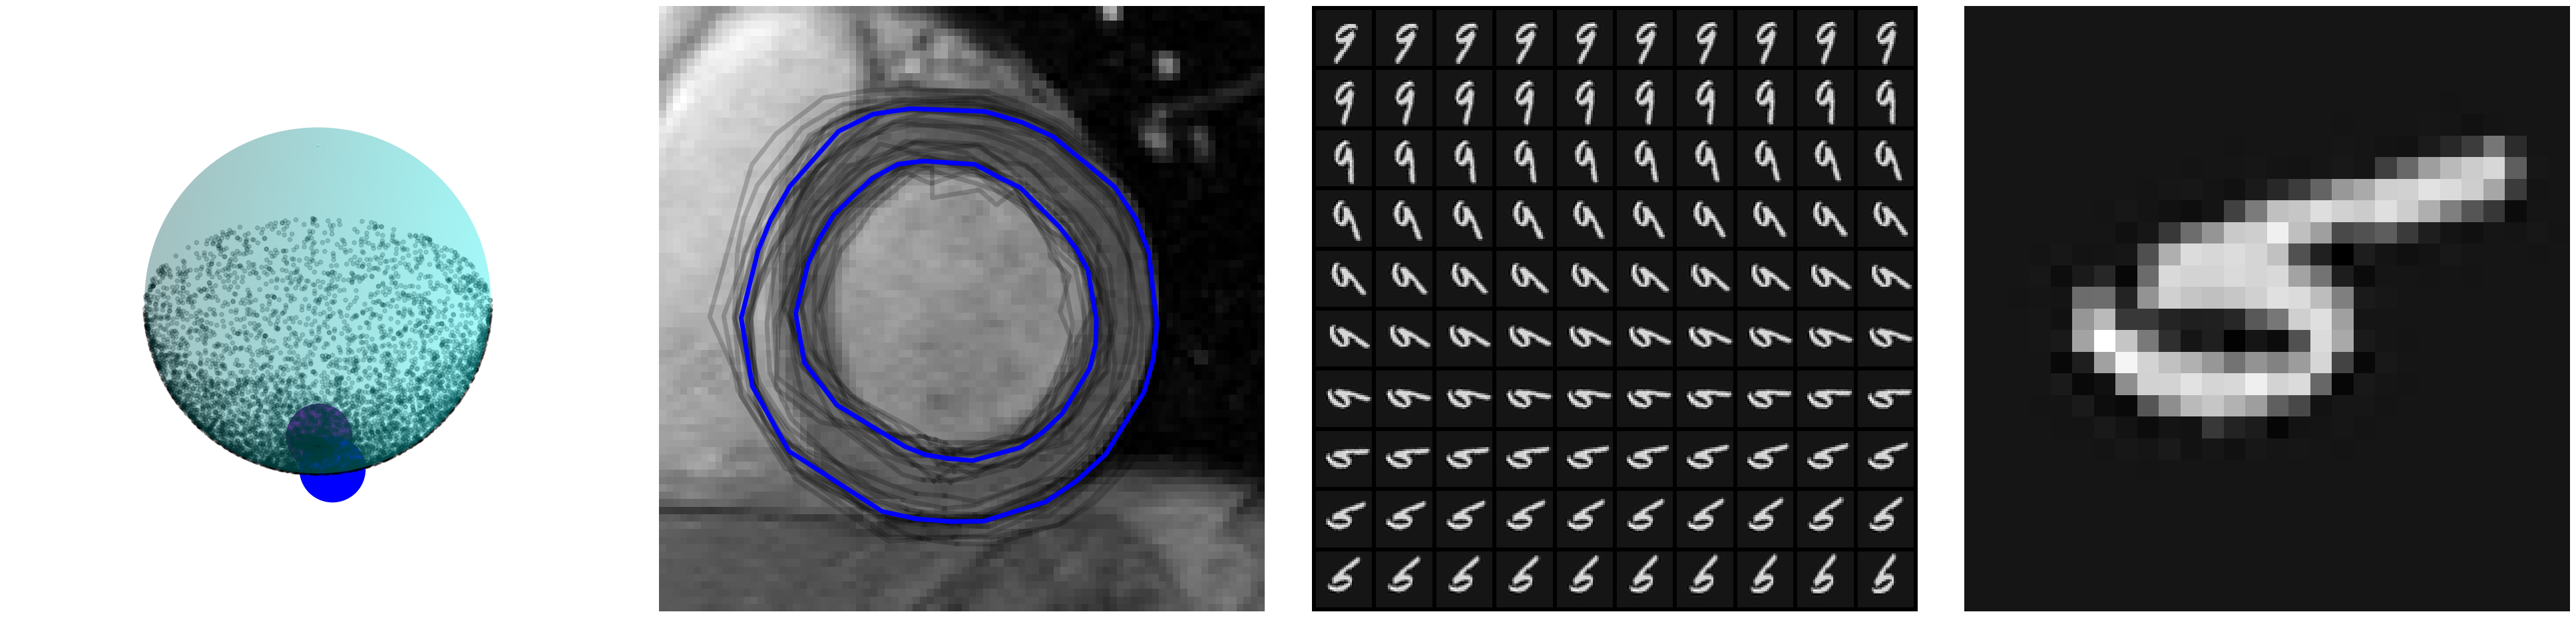

In [73]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(40,10))
color = ['magenta', 'red', 'green', 'orange']

#Landmarks
ax = fig.add_subplot(141, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(musphere_sm[1][-1,0], musphere_sm[1][-1,1], musphere_sm[1][-1,2], color='blue', alpha=1.0, s=5000, label='Score Matching')
ax.scatter(musphere_opt[1][-1,0], musphere_opt[1][-1,1], musphere_sm[1][-1,2], color='purple', alpha=1.0, s=5000, label='Diffuson Mean')
ax.scatter(Xsphere_obs[1][:,0], Xsphere_obs[1][:,1], Xsphere_obs[1][:,2], color='black', alpha=0.2, label='Data')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(142)
ax.imshow(cardiac_image, interpolation='none', extent=[-150.0,150.0, -150.0, 150.0], cmap='gray')
ax.set_aspect(1)
mu = mulandmark_sm[0][-1].reshape(-1,2)/1
for wing in landmark_data:
    wing = wing.reshape(-1,2)/1
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2,linewidth=5)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2, linewidth=5)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue', linewidth=5)
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue', linewidth=5)
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

#R3
#ax = fig.add_subplot(143, projection='3d')
#ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[:,:,-1]/jnp.amax(R3_l2[:,:,-1])), alpha=0.5)
#ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[:,0,:]/jnp.amax(R3_l2[:,0,:])), alpha=0.5)
#ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[:,-1,:]/jnp.amax(R3_l2[:,-1,:])), alpha=0.5)
#ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[0,:,:]/jnp.amax(R3_l2[0,:,:])), alpha=0.5)
#ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=mpl.cm.inferno(R3_l2[-1,:,:]/jnp.amax(R3_l2[-1,:,:])), alpha=0.5)
#ax.set_box_aspect([1,1,1])
#ax.autoscale(False)
#ax.set_axis_off()
#m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
#heat_map = jnp.stack((R3_l2[:,:,0],
#                     R3_l2[:,:,-1],
#                     R3_l2[:,0,:],
#                     R3_l2[:,-1,:],
#                     R3_l2[0,:,:],
#                     R3_l2[-1,:,:]))
#m.set_array(heat_map)
#divider = make_axes_locatable(ax)
#cax = plt.axes([0.70, 0.12, 0.01, 0.80])
#fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax
import torch
import torchvision.utils as vutils

mnist_data = torch.Tensor(np.array(data_post.reshape(-1,1,28,28)))
ax = fig.add_subplot(143)
ax.imshow(np.transpose(vutils.make_grid(mnist_data.to('cpu'), padding=2, normalize=True, nrow=10).cpu(),(1,2,0)))
ax.set_axis_off()

test = RMEG.post_mom(mulandmark_mnist[0][-1])[0]
ax = fig.add_subplot(144)
ax.imshow(test.reshape(28,28), cmap='gray')
ax.set_axis_off()

#ax = fig.add_subplot(144, projection='3d')
#intervals = 100
#ntheta = intervals
#nphi = 2*intervals
#theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
#phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
#X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
#X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
#X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
#X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
#                     X2.reshape(1, ntheta+1, nphi+1), 
#                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(centroidseuc_s2[1][:,0], centroidseuc_s2[1][:,1], centroidseuc_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
#for i in range(len(centroideuc_idxs_s2)):
#    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
#               X_obs[1][centroidsm_idxs_s2[i],1], 
#               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.2, s=100, color=color[i], label='Cluser ' + str(i+1))
#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
#ax.set_axis_off()
fig.tight_layout()

plt.show()

fig.savefig('Figures/rebutal_aistat.png', format='png', pad_inches=0.1, bbox_inches='tight')


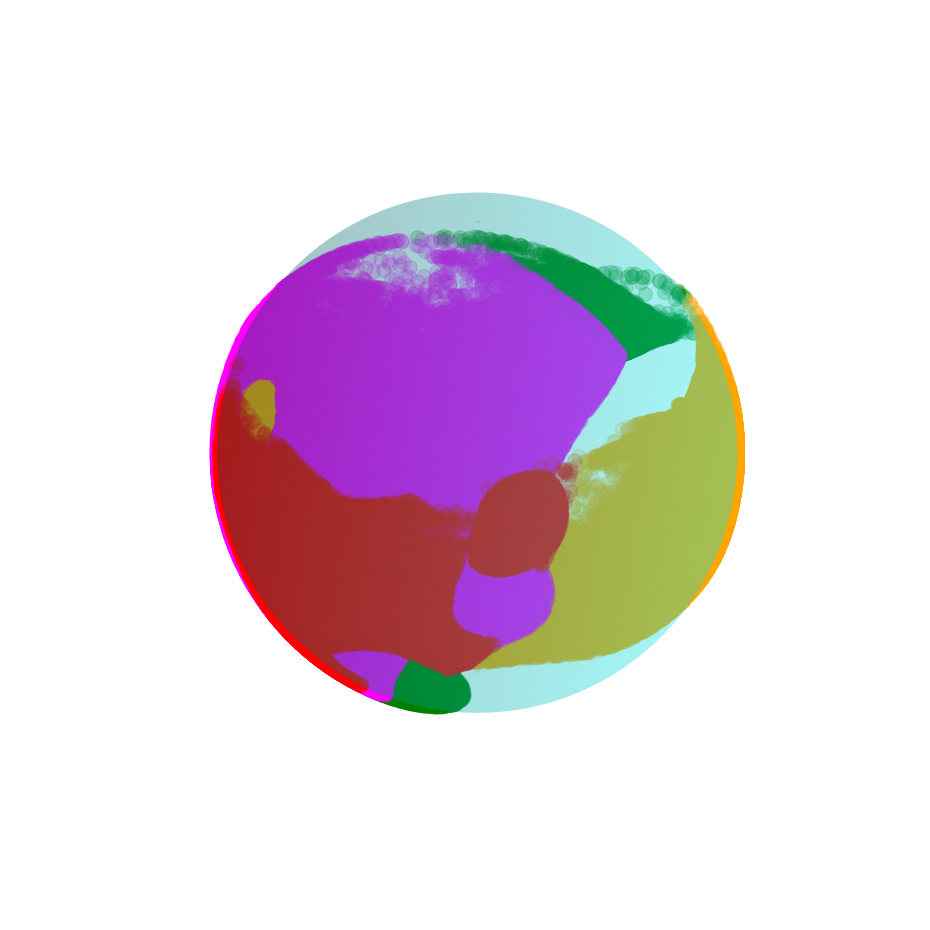

In [202]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(centroidseuc_s2[1][:,0], centroidseuc_s2[1][:,1], centroidseuc_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
for i in range(len(centroideuc_idxs_s2)):
    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
               X_obs[1][centroidsm_idxs_s2[i],1], 
               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.2, s=100, color=color[i], label='Cluser ' + str(i+1))
#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

NameError: name 'muspdn_sm' is not defined

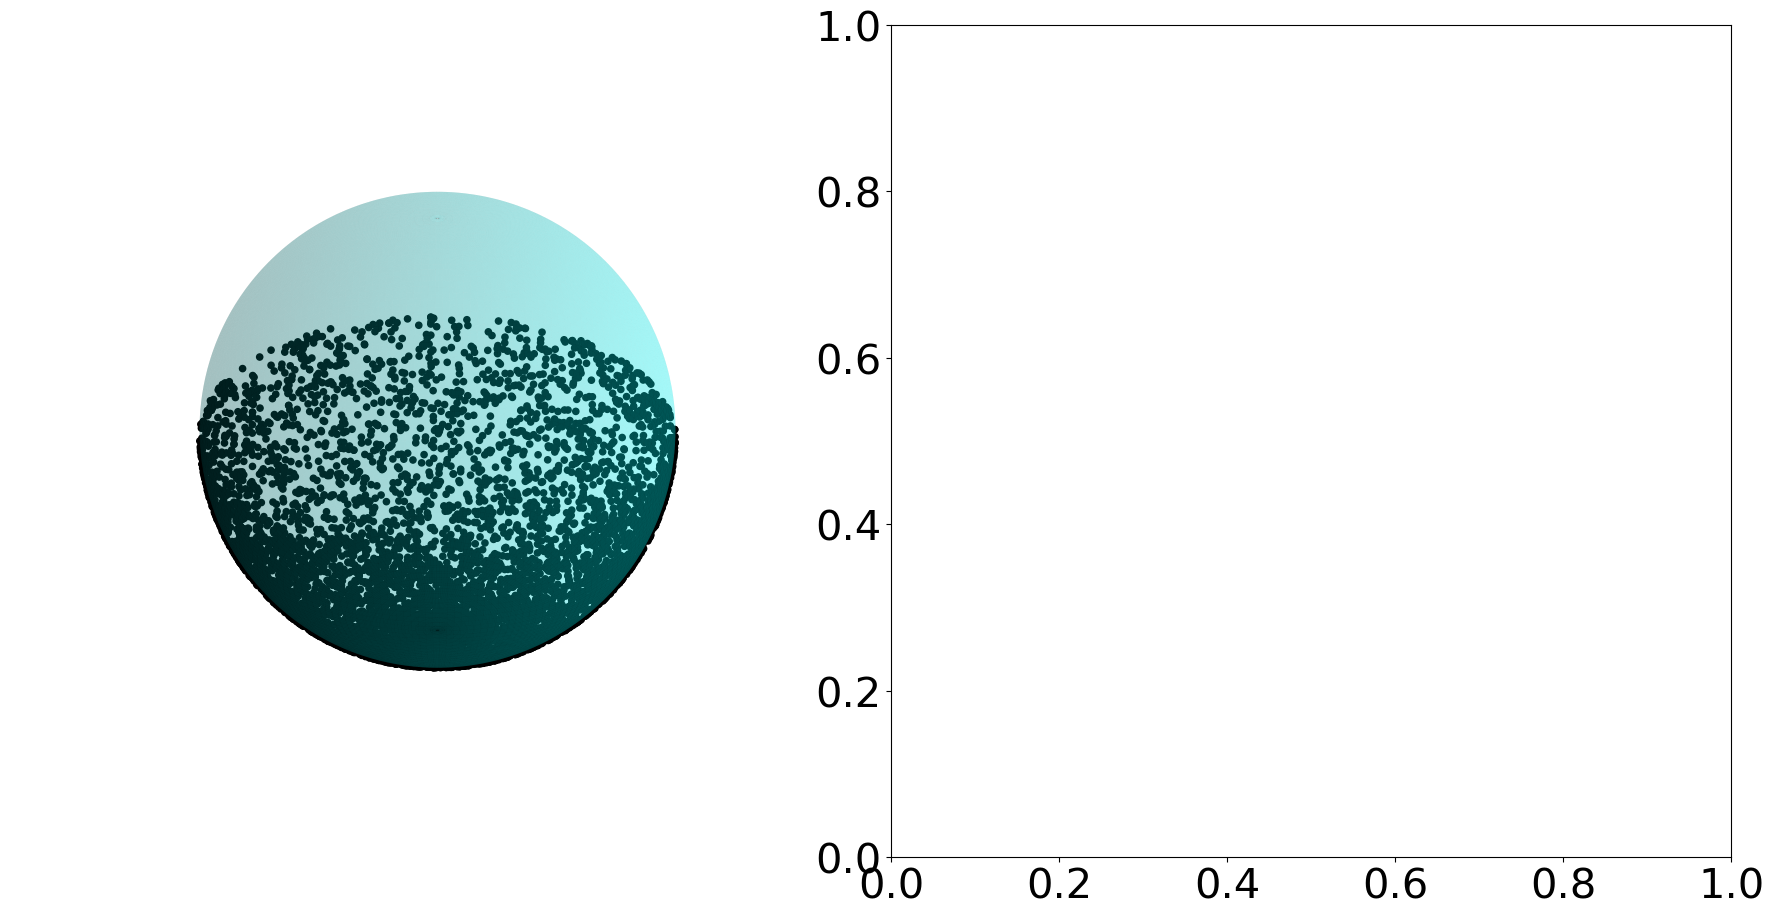

In [322]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(27,18))

#Landmarks
ax = fig.add_subplot(231, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(musphere_sm[1][-1,0], musphere_sm[1][-1,1], musphere_sm[1][-1,2], color='blue', alpha=1.0, s=100, label='Score Matching')
ax.scatter(musphere_opt[1][-1,0], musphere_opt[1][-1,1], musphere_sm[1][-1,2], color='purple', alpha=1.0, s=100, label='Diffuson Mean')
ax.scatter(Xsphere_obs[1][:,0], Xsphere_obs[1][:,1], Xsphere_obs[1][:,2], color='black', alpha=1.0, label='Data')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(232)
ax.imshow(muspdn_sm[1][-1].reshape(10,10), cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(muspdn_sm[1][-1].reshape(10,10))
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

ax = fig.add_subplot(233)
mu = mulandmark_sm[0][-1].reshape(-1,2)
for wing in landmark_data:
    wing = wing.reshape(-1,2)
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(234)
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_sm, color='blue')
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_opt[-1]*jnp.ones(len(Tsphere_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Diffusion Variance')
fig.tight_layout()

ax = fig.add_subplot(235)
ax.plot(jnp.arange(1,len(Tspdn_sm)+1, 1), Tspdn_sm, color='blue')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

ax = fig.add_subplot(236)
ax.plot(jnp.arange(1,len(Tlandmark_sm)+1, 1), Tlandmark_sm, color='blue')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.1), ncol=5)

plt.show()

fig.savefig('Figures/diffusion_mean_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


# Clustering

### $\mathbb{S}^{2}$

In [109]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [110]:
file_path = 'scores/S2/vsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [111]:
from scipy.io import loadmat

sphere_data = loadmat('../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [112]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [113]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

def frechet_fun(X_obs, X_init, t=0.1):
    
    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

#def frechet_fun(X_obs, X_init, t=0.01):
    
#    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [114]:
from jaxgeometry.statistics.score_matching import kmeans

In [115]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [136]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [137]:
centroidssm_s2, centroidsm_idxs_s2 = RMK.centroids, RMK.centroid_idx

### $\mathbb{S}^{2}$

In [138]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [139]:
file_path = 'scores/S2/vsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [140]:
from scipy.io import loadmat

sphere_data = loadmat('../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [141]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [142]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

#def frechet_fun(X_obs, X_init, t=0.1):
    
#    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
#    return (mu[0][-1], mu[1][-1])

def frechet_fun(X_obs, X_init, t=0.01):
    
    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [143]:
from jaxgeometry.statistics.score_matching import kmeans

In [145]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [146]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [147]:
centroidseuc_s2, centroideuc_idxs_s2 = RMK.centroids, RMK.centroid_idx

## Landmarks

In [37]:
N_sample = 30
N_half = N_sample // 2

In [39]:
data = pd.read_csv('../../../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [41]:
with open('../../../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [42]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    landmark_data.append(jnp.vstack((data1, data2)).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [43]:
M = Landmarks(N=N_sample,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

using M.Exp for Logarithm


In [44]:
file_path = 'scores/Landmarks'+str(N_sample)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if 2*N_sample<10:
    layers = [50,100,100,50]
elif 2*N_sample<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [45]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [80]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

def frechet_fun(X_obs, X_init, t=0.1):
    
    mu = M.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

#def frechet_fun(X_obs, X_init, t=0.01):
    
#    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [81]:
from jaxgeometry.statistics.score_matching import kmeans

In [82]:
frechet_fun((landmark_data, jnp.zeros(len(landmark_data))), (landmark_data[0], jnp.zeros(1)))

(Array([  963.8528 ,  -568.2925 ,   812.1709 ,  -357.8545 ,   604.0095 ,
         -194.82944,   461.60522,  -292.96057,   530.4612 ,  -538.5249 ,
          686.8884 ,  -639.812  ,   565.83203,  -813.2739 ,   592.57104,
         -991.92017,   744.37476, -1034.9146 ,   880.80664,  -893.9868 ,
         1296.4648 ,  -647.2068 ,  1468.2905 ,  -502.37988,  1542.5322 ,
         -259.30945,  1346.6631 ,  -223.8322 ,  1147.3628 ,  -399.5067 ,
         1025.127  ,  -735.6948 ,  1118.3237 ,  -938.69604,  1270.4551 ,
        -1051.4604 ,  1398.0557 ,  -967.88525,  1406.5942 ,  -777.7571 ],      dtype=float32),
 Array([0.], dtype=float32))

In [83]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [85]:
RMK.fit((landmark_data, jnp.zeros(len(landmark_data)))) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [86]:
centroidssm_landmark, centroidsm_idxs_landmark = RMK.centroids, RMK.centroid_idx

## Landmarks

In [98]:
N_sample = 20
N_half = N_sample // 2

In [99]:
data = pd.read_csv('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [100]:
with open('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [101]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    landmark_data.append(jnp.vstack((data1, data2)).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [102]:
M = Landmarks(N=N_sample,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

using M.Exp for Logarithm


In [103]:
file_path = 'scores/Landmarks'+str(N_sample)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if 2*N_sample<10:
    layers = [50,100,100,50]
elif 2*N_sample<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [112]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[0]-y[0])

In [118]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

#def frechet_fun(X_obs, X_init, t=0.1):
    
#    mu = M.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
#    return (mu[0][-1], mu[1][-1])

def frechet_fun(X_obs, X_init, t=0.01):
    
    return (jnp.mean(X_obs[0], axis=0), jnp.zeros(1))
    

In [119]:
from jaxgeometry.statistics.score_matching import kmeans

In [121]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [122]:
RMK.fit((landmark_data, jnp.zeros(len(landmark_data)))) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [123]:
centroidseuc_landmark, centroidseuc_idxs_landmark = RMK.centroids, RMK.centroid_idx

### Plotting

In [ ]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(30,10))
color = ['magenta', 'red', 'green', 'orange']

#Landmarks
ax = fig.add_subplot(141, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(centroidseuc_s2[1][:,0], centroidseuc_s2[1][:,1], centroidseuc_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
for i in range(len(centroideuc_idxs_s2)):
    ax.scatter(X_obs[1][centroideuc_idxs_s2[i],0], 
               X_obs[1][centroideuc_idxs_s2[i],1], 
               X_obs[1][centroideuc_idxs_s2[i],2], alpha=0.2, s=100, color=color[i], label='Cluser ' + str(i+1))
#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()
fig.tight_layout()

ax = fig.add_subplot(142, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(centroidssm_s2[1][:,0], centroidssm_s2[1][:,1], centroidssm_s2[1][:,2], color='blue', alpha=1.0, s=300)
for i in range(len(centroideuc_idxs_s2)):
    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
               X_obs[1][centroidsm_idxs_s2[i],1], 
               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.2, s=100, color=color[i])
#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(143)
for i in range(len(centroidseuc_idxs_landmark)):
    for wing in landmark_data[centroidseuc_idxs_landmark[i]]:
        wing = wing.reshape(-1,2)
        ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color=color[i], alpha=0.2)
        ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color=color[i], alpha=.2)
for mu in centroidseuc_landmark[0]:
    mu = mu.reshape(-1,2)
    ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
    ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
    ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
    ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(144)
for i in range(len(centroidsm_idxs_landmark)):
    for wing in landmark_data[centroidsm_idxs_landmark[i]]:
        wing = wing.reshape(-1,2)
        ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color=color[i], alpha=0.2)
        ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color=color[i], alpha=.2)
for mu in centroidssm_landmark[0]:
    mu = mu.reshape(-1,2)
    ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
    ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
    ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
    ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.2,0.1), ncol=5)

plt.show()

fig.savefig('Figures/kmeans_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')